# Data Madness
## Group number 30
### Collaborators: Spencer Olson (i6260490), Oscar van Bommel Barcia (i6260219), Aurélien Bertrand (i6256590)

# **The secrets behind European air quality data.**
![image](pogchamp-pepe.gif)

# Import relevant libraries

In [1]:
import pandas as pd
import numpy as np

import os
import glob

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

from countryinfo import CountryInfo

import warnings
warnings.filterwarnings("ignore")

# Read the data as given by the webscrapping

The website from which we downloaded the data only allowed us to download up 100 000 rows of data. Given that the entire dataset contained upwards of 10 million rows, we had to be selective about our filters. The interface used to set filters was also very slow and any changes to the filters led to loading times of around 15-20 seconds. This wouldn't be problem if the filters would allow us to select multiple years and countries at the same time. However, this was not possible and we would have to download each year and country one-by-one. This is where we decided to automate the process. Using the Selenium python package, we were able to automate the browser interaction and download each country-year pair automatically.

For the countries and years, we considered the last 30 years (1993 - 2023) and the following countries: Netherlands, France, Germany, Greece, Hungray, Belgium and Luxembourg. Once up and running, the webscraper took about 2 hours to collect around 1.5 million rows of data. 

In [2]:
df = pd.DataFrame()
for i, d in enumerate(os.listdir('data')):
    if '.csv' in d: os.rename('data/'+d, f'data/DataExtact-{i}')

for p in glob.glob('data/**/*.csv'):
    df = pd.concat([df, pd.read_csv(p)])

df = df.drop_duplicates()

print(len(df))

1543541


In [3]:
print(np.sum(df.duplicated()))

0


In [4]:
def getArea(country_name):
    return CountryInfo(country_name).info()['area']

def getPop(country_name):
    return CountryInfo(country_name).info()['population']

country_df = pd.DataFrame()
country_df['Country'] = df['Country'].unique()
country_df['Area'] = country_df['Country'].apply(getArea)
country_df['Population'] = country_df['Country'].apply(getPop)


EDA
--
To start off, we want to look at the pollutants for which we have the most data, as well as, pollutants that we researched to be relevant. So we limit ourselves to the following pollutants:

In [ ]:
pollutants = ['CO', 'SO2', 'PM2.5', 'PM10', 'NO2']
poll_df = df.loc[df['Air Pollutant'].isin(pollutants)]

Let's check what the data looks like

In [ ]:
poll_df.head(5)

,Country,Air Quality Network,Air Quality Network Name,Air Quality Station EoI Code,Air Quality Station Name,Sampling Point Id,Air Pollutant,Air Pollutant Description,Data Aggregation Process Id,Data Aggregation Process,...,Air Quality Station Area,Longitude,Latitude,Altitude,City,City Code,City Population,Source Of Data Flow,Calculation Time,Link to raw data (only E1a/validated data from AQ e-Reporting)
0,Luxembourg,NET-LU005A,Air Quality Luxembourg,LU0102A,Esch/Alzette,SPO-LU0102A_00008_100,NO2,Nitrogen dioxide (air),P1Y-hr-per50,1 year 50 percentile,...,urban,5.9769,49.5050,287.0,NaN,NaN,NaN,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
2,Luxembourg,NET-LU005A,Air Quality Luxembourg,LU0104A,Beckerich,SPO-LU0104A_06001_100,PM2.5,Particulate matter < 2.5 µm (aerosol),P1Y,Annual mean / 1 calendar year,...,rural,5.8471,49.7318,288.0,NaN,NaN,NaN,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
7,Luxembourg,NET-LU005A,Air Quality Luxembourg,LU0105A,Beidweiler,SPO-LU0105A_00001_100,SO2,Sulphur dioxide (air),P1Y-hr-max,1 year hour max,...,rural,6.3053,49.7223,319.0,NaN,NaN,NaN,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
12,Luxembourg,NET-LU005A,Air Quality Luxembourg,LU0101A,Luxembourg Bonnevoie,SPO-LU0101A_00005_100,PM10,Particulate matter < 10 µm (aerosol),P1Y-day-max,1 year day max,...,urban,6.1376,49.5977,275.0,Luxembourg ...,LU001C1 ...,115227.0,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
13,Luxembourg,NET-LU005A,Air Quality Luxembourg,LU0102A,Esch/Alzette,SPO-LU0102A_00010_100,CO,Carbon monoxide (air),P1Y-dx-max,1 year day max max,...,urban,5.9769,49.5050,287.0,NaN,NaN,NaN,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN


Notice that the same information about pollution is collected from different places in a single country. Those might lead to different observations. Further, the data is collected in different ways within the same location. Let's have a look at what we should care about.

In [ ]:
poll_df['Data Aggregation Process'].unique()

array(['1 year 50 percentile', 'Annual mean / 1 calendar year',
       '1 year hour max', '1 year day max', '1 year day max max',
       '1 year 50 %ile of daily values in a year', '1 year hour max 25',
       '1 year daymax average', '1 year 90.41 percentile',
       '1 year 99.79 %ile of hourly values in a given year',
       '1 year day exceed 50', '1 year hour max19',
       '1 year 99.73 %ile of hourly values in a given year',
       '1 year day exceed 125', '1 year hour exceed 200',
       '1 year 99.18 percentile of daily maximum', '1 year day max 36',
       '1 year day max 4', '1 year hour exceed 350',
       '1 year hour exceed 400',
       '1 year 99 percentile of daily means (P1D) or .../aq/primaryObservation/day',
       '1 year daymax exceed 10', '1 year day min',
       '1 year 90.4 percentile - COMPLIANCE', '1 year hour min',
       '3 consecutive hours in exceedance of 400',
       '3 consecutive hours in exceedance of 500',
       '3 subsequent calendar years mean', '

In this case, we are interested in the `Annual mean / 1 calendar year` as this gives the target information, the average observation of the quantity of that pollutant in the air quality of a country in a given year.

In [ ]:
poll_df = poll_df.loc[poll_df['Data Aggregation Process'] == 'Annual mean / 1 calendar year']
poll_df.groupby('Air Pollutant').agg({'Unit Of Air Pollution Level': 'unique'})

,Unit Of Air Pollution Level
Air Pollutant,
CO,[mg/m3]
NO2,[ug/m3]
PM10,[ug/m3]
PM2.5,[ug/m3]
SO2,[ug/m3]


The units are not the same across all pollutants. We will then convert the `CO` from `mg/m3` to `ug/m3`.

In [ ]:
mask = poll_df['Unit Of Air Pollution Level'] == 'mg/m3'
poll_df.loc[mask, 'Air Pollution Level'] = poll_df.loc[mask, 'Air Pollution Level'] * 1000
poll_df.loc[mask, 'Unit Of Air Pollution Level'] = 'ug/m3'

Let's see what the data looks like again

In [ ]:
poll_df.head(10)

,Country,Air Quality Network,Air Quality Network Name,Air Quality Station EoI Code,Air Quality Station Name,Sampling Point Id,Air Pollutant,Air Pollutant Description,Data Aggregation Process Id,Data Aggregation Process,...,Air Quality Station Area,Longitude,Latitude,Altitude,City,City Code,City Population,Source Of Data Flow,Calculation Time,Link to raw data (only E1a/validated data from AQ e-Reporting)
2,Luxembourg,NET-LU005A,Air Quality Luxembourg,LU0104A,Beckerich,SPO-LU0104A_06001_100,PM2.5,Particulate matter < 2.5 µm (aerosol),P1Y,Annual mean / 1 calendar year,...,rural,5.8471,49.7318,288.0,NaN,NaN,NaN,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
19,Luxembourg,NET-LU005A,Air Quality Luxembourg,LU0100A,Luxembourg Centre,SPO-LU0100A_00001_100,SO2,Sulphur dioxide (air),P1Y,Annual mean / 1 calendar year,...,urban,6.1263,49.6115,280.0,Luxembourg ...,LU001C1 ...,115227.0,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
22,Luxembourg,NET-LU005A,Air Quality Luxembourg,LU0102A,Esch/Alzette,SPO-LU0102A_00001_100,SO2,Sulphur dioxide (air),P1Y,Annual mean / 1 calendar year,...,urban,5.9769,49.5050,287.0,NaN,NaN,NaN,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
37,Luxembourg,NET-LU005A,Air Quality Luxembourg,LU0102A,Esch/Alzette,SPO-LU0102A_00008_100,NO2,Nitrogen dioxide (air),P1Y,Annual mean / 1 calendar year,...,urban,5.9769,49.5050,287.0,NaN,NaN,NaN,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
43,Luxembourg,NET-LU005A,Air Quality Luxembourg,LU0104A,Beckerich,SPO-LU0104A_00005_100,PM10,Particulate matter < 10 µm (aerosol),P1Y,Annual mean / 1 calendar year,...,rural,5.8471,49.7318,288.0,NaN,NaN,NaN,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
56,Luxembourg,NET-LU005A,Air Quality Luxembourg,LU0102A,Esch/Alzette,SPO-LU0102A_00005_100,PM10,Particulate matter < 10 µm (aerosol),P1Y,Annual mean / 1 calendar year,...,urban,5.9769,49.5050,287.0,NaN,NaN,NaN,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
81,Luxembourg,NET-LU005A,Air Quality Luxembourg,LU0100A,Luxembourg Centre,SPO-LU0100A_00005_100,PM10,Particulate matter < 10 µm (aerosol),P1Y,Annual mean / 1 calendar year,...,urban,6.1263,49.6115,280.0,Luxembourg ...,LU001C1 ...,115227.0,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
121,Luxembourg,NET-LU005A,Air Quality Luxembourg,LU0105A,Beidweiler,SPO-LU0105A_00008_100,NO2,Nitrogen dioxide (air),P1Y,Annual mean / 1 calendar year,...,rural,6.3053,49.7223,319.0,NaN,NaN,NaN,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
142,Luxembourg,NET-LU005A,Air Quality Luxembourg,LU0105A,Beidweiler,SPO-LU0105A_00001_100,SO2,Sulphur dioxide (air),P1Y,Annual mean / 1 calendar year,...,rural,6.3053,49.7223,319.0,NaN,NaN,NaN,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN
167,Luxembourg,NET-LU005A,Air Quality Luxembourg,LU0106A,Walferdange,SPO-LU0106A_00005_100,PM10,Particulate matter < 10 µm (aerosol),P1Y,Annual mean / 1 calendar year,...,suburban,6.1302,49.6590,230.0,NaN,NaN,NaN,Reporting within EoI/AirBase 8,31/12/2012 00:00:00,NaN


Looking at the dataset, we'll also notice the 'Verification' column. The documentation of the dataset describes this field as a flag that denotes whether the calculation was verified, preliminarily verified, or not verified. For our purposes, and for the sake of keeping things as clean as possible, we will only consider calculations that have been verified or preliminarily verified. Note that the verification column also contains 'NaN'-s. These calculations are ones that were done before a proper verification were set in place, and therefore we treat this values as verified.

Now that we've loaded the relevant data, let's look at how the data is distributed. We will do this using a set of box plots. Each plot represents the distribtion of measurements of a given air pollutant per country.

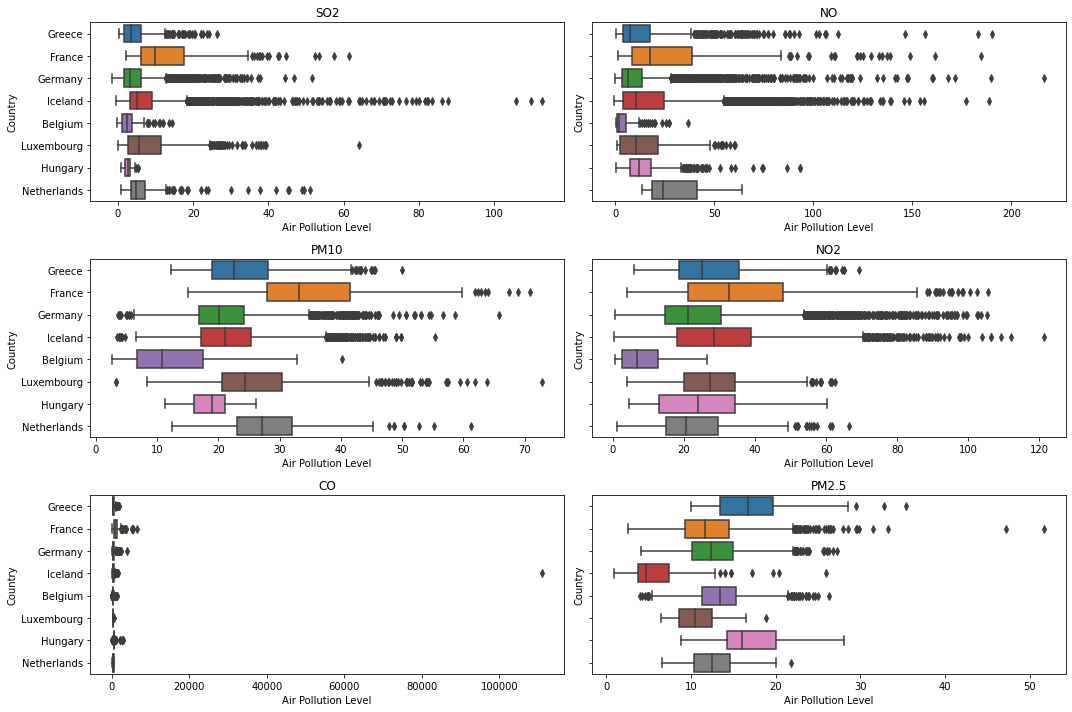

In [ ]:
def verified(df):
    temp = df[(df['Verification'] == 1) | (df['Verification'] == 2) | (df['Verification'].isnull())]
    return temp[temp['Data Coverage'] >= 75]

fig, ax = plt.subplots(3, 2, tight_layout=True, figsize=(15,10), sharey=True)
verified_df = poll_df.pipe(verified)
for i, p in enumerate(verified_df['Air Pollutant'].unique()):
    sns.boxplot(data=verified_df[verified_df['Air Pollutant']==p], x='Air Pollution Level', y='Country', ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(p)


At a quick glance, we can tell that several distributions show huge outliers. For example, the plot showing the distribution of CO (Carbon monoxide) measurements. All data points are fairly well distributed except for two measurements made in Belgium. Let's investigate these points individually.

In [ ]:
display(verified_df.loc[(verified_df['Air Pollution Level'] >= 10000) & (verified_df['Air Pollutant'] == 'CO')])
verified_df['Verification'].unique()

,Country,Air Quality Network,Air Quality Network Name,Air Quality Station EoI Code,Air Quality Station Name,Sampling Point Id,Air Pollutant,Air Pollutant Description,Data Aggregation Process Id,Data Aggregation Process,...,Air Quality Station Area,Longitude,Latitude,Altitude,City,City Code,City Population,Source Of Data Flow,Calculation Time,Link to raw data (only E1a/validated data from AQ e-Reporting)
25482,Germany,NET.DE_UB,Bryan Hellack,DEUB044,Zugspitze Schneefernerhaus,SPO.DE_DEUB044_CO_dataGroup1,CO,Carbon monoxide (air),P1Y,Annual mean / 1 calendar year,...,Rural,10.9807,47.4144,2650.0,NaN,NaN,NaN,E1a/validated data AQ e-Reporting,18/03/2023 21:08:58,http://fme.discomap.eea.europa.eu/fmedatastrea...


array([nan,  1.,  2.])

Looking at this example, we can see a problem. The 'Verification' column seems to denote that the calculation is verified. Regardless of this verified flag, this outlier has the potential to bog us down in future calculations. How this anomaly showed up, we do not know, but we will remove it from the calculations, because we are mostly concerned with the aggregate pollution values across a whole country. We removed the outliers for each pollutant respectively. 

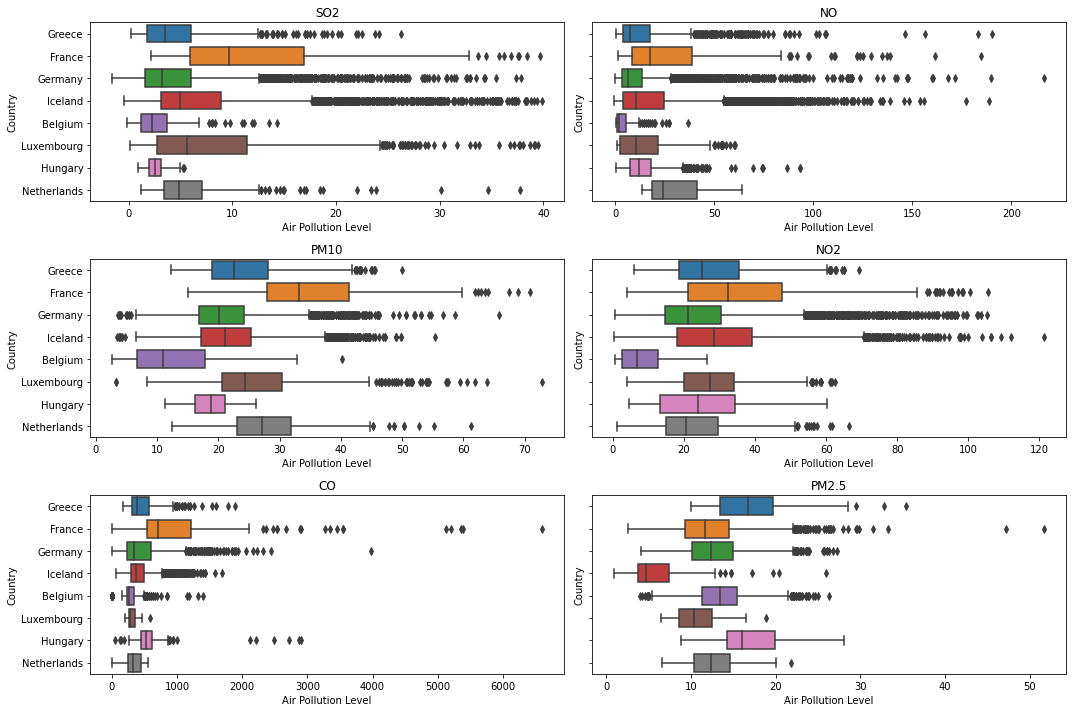

In [ ]:
def remove_anomalies(df):
    thresholds = {
        'NO2': 250,
        'NO': 250,
        'PM2.5': 80,
        'PM10': 80,
        'SO2': 40,
        'CO': 20000
    }
    for p in df['Air Pollutant'].unique():
        df = df.drop(df[((df['Air Pollutant']==p) & (df['Air Pollution Level'] >= thresholds[p]))].index, axis=0) 
    
    return df

fig, ax = plt.subplots(3, 2, tight_layout=True, figsize=(15,10), sharey=True)
clean_df = verified_df.pipe(remove_anomalies)
for i, p in enumerate(clean_df['Air Pollutant'].unique()):
    sns.boxplot(data=clean_df[(clean_df['Air Pollutant']==p)], x='Air Pollution Level', y='Country', ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(p)

## Q1. Is there correlation between the altitude and the level pollutants in the atmosphere

Now that the data has been cleaned up somewhat, let's do some investigation on how some variables might be correlated.

First let's see if there is a relationship between the altitude of a measuring station and the levels of air pollution. We're only concerned in recent measurements, therefore we'll only take into account the last 5 years.

Below we have the same grid, wher each plot visualizes a given pollutant. In each plot, you can see a scatter plot of 'Altitude' (x-axis) vs. 'Air Pollution Level' (y-axis). Overlaid on top of the scatter plot (red line) is a LOWESS estimation of the that scatter plot.

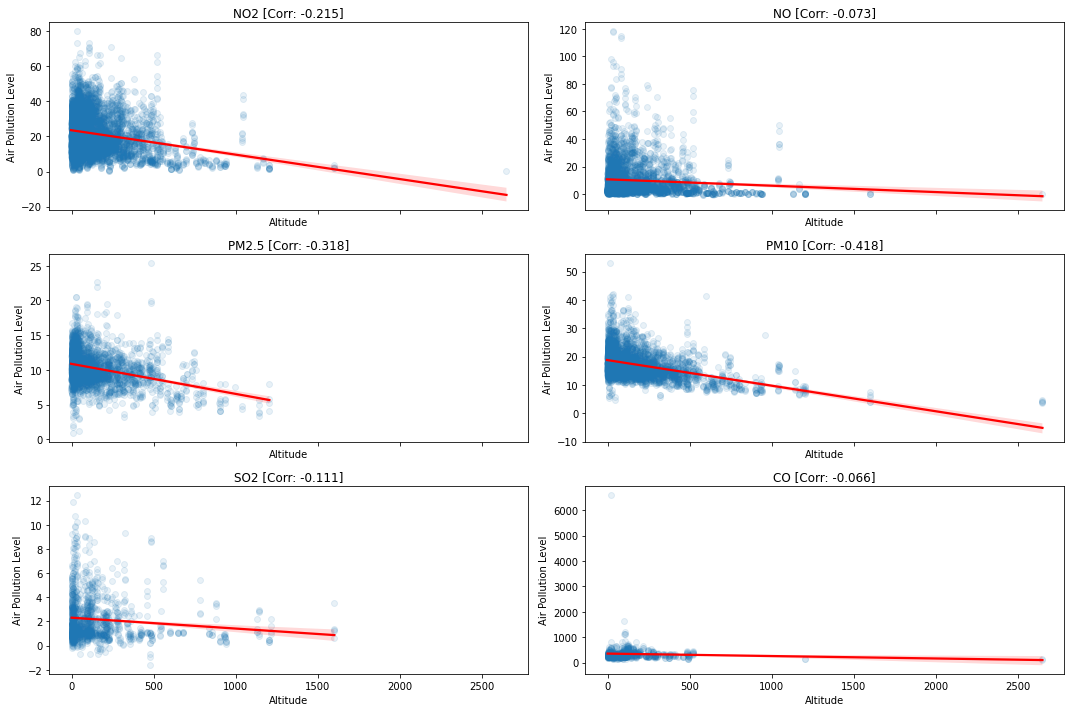

In [ ]:
fig, ax = plt.subplots(3, 2, tight_layout=True, figsize=(15,10), sharex=True)
clean_df = clean_df[clean_df['Year'] >= 2018]
for i, p in enumerate(clean_df['Air Pollutant'].unique()):
    clean_poll_df = clean_df[clean_df['Air Pollutant']==p]
    clean_poll_df = clean_poll_df.merge(country_df, on='Country')

    # for c in clean_poll_df['Country'].unique():
        # sns.regplot(data=clean_poll_df[(clean_poll_df['Country'] == c)], x='Altitude', y='Air Pollution Level', ax=ax[i//2, i%2])
    # sns.scatterplot(data=clean_poll_df, x='Altitude', y='Air Pollution Level',  ax=ax[i//2, i%2])
    corr = np.corrcoef(clean_poll_df['Altitude'], clean_poll_df['Air Pollution Level'])
    sns.regplot(data=clean_poll_df, x='Altitude', y='Air Pollution Level',  ax=ax[i//2, i%2], scatter_kws={'alpha': 0.1}, line_kws={'color': 'red'})
    # sns.residplot(data=clean_poll_df, x='Altitude', y='Air Pollution Level',  ax=ax[i//2, i%2], scatter_kws={'alpha': 0.1}, line_kws={'color': 'red'})

    ax[i//2, i%2].set_title(f'{p} [Corr: {np.round(corr[0, 1], 3)}]')

In the above plots, we can see a clear negative correlation (especially for pollutants NO2, PM2.5, PM10 and SO2). This shows, that for the pollutants we are interested in, the higher the altitude, the less air pollution that's expected. 

## Q2. Is there a correlation between the size of a country and its pollution levels
Next we'll look at the correlation between country/city size and pollution levels. Below you'll see three sets of graphs. They are the same format as the previous one. The sets of plots compare air pollution based on country area (in km^2), city population and country population respectively.

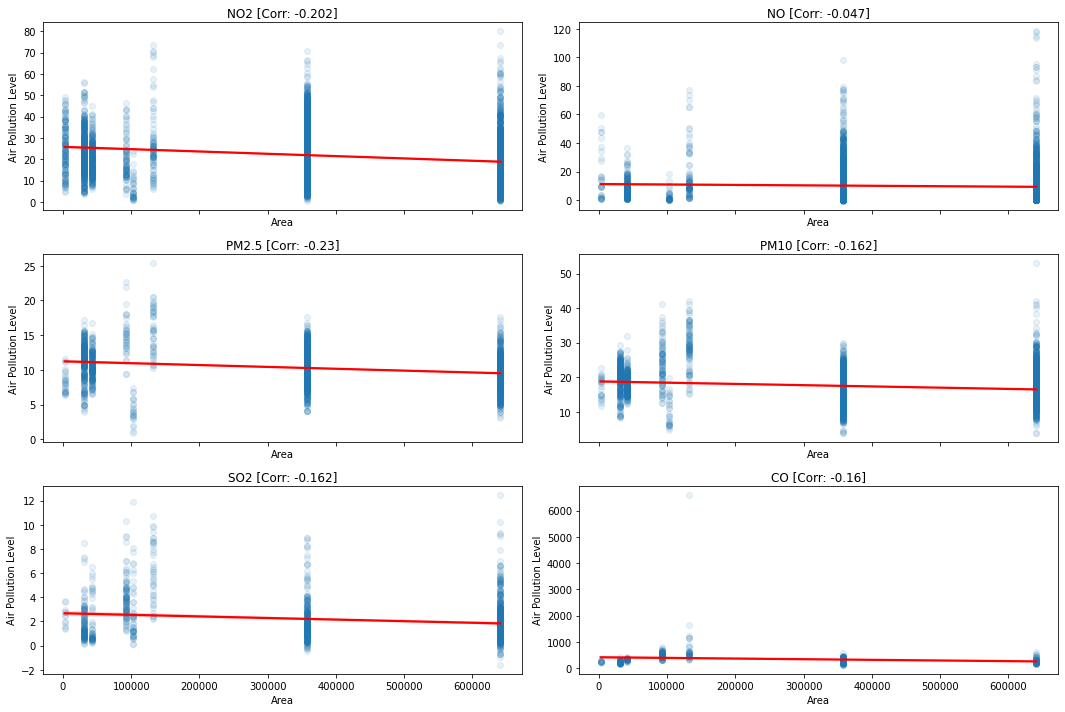

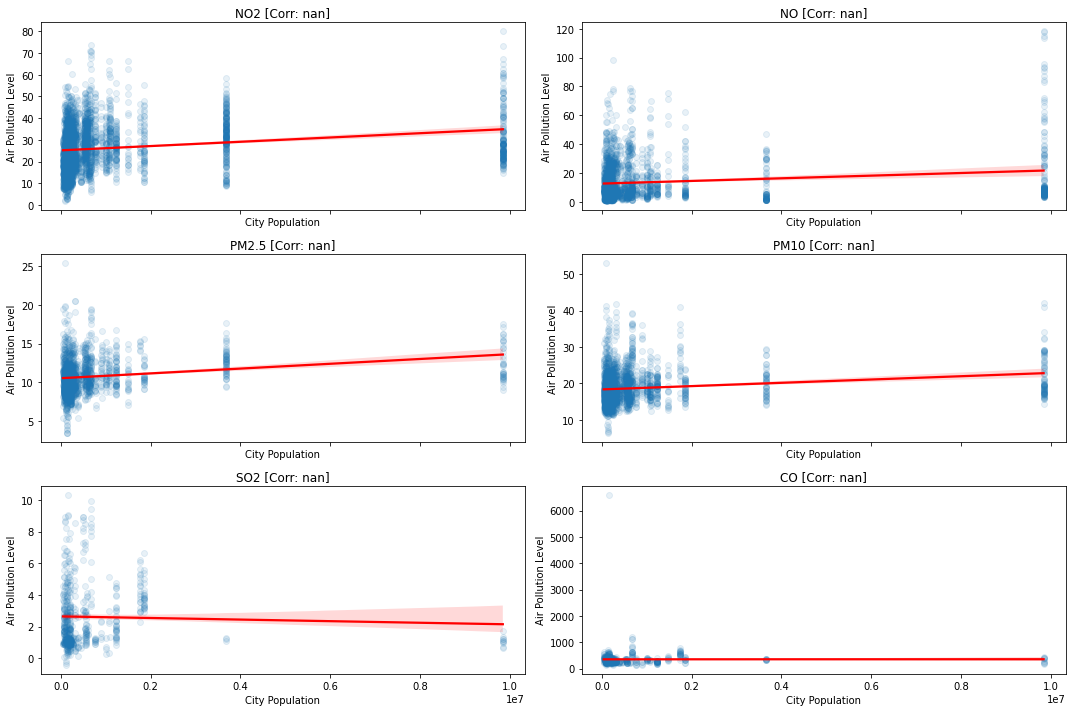

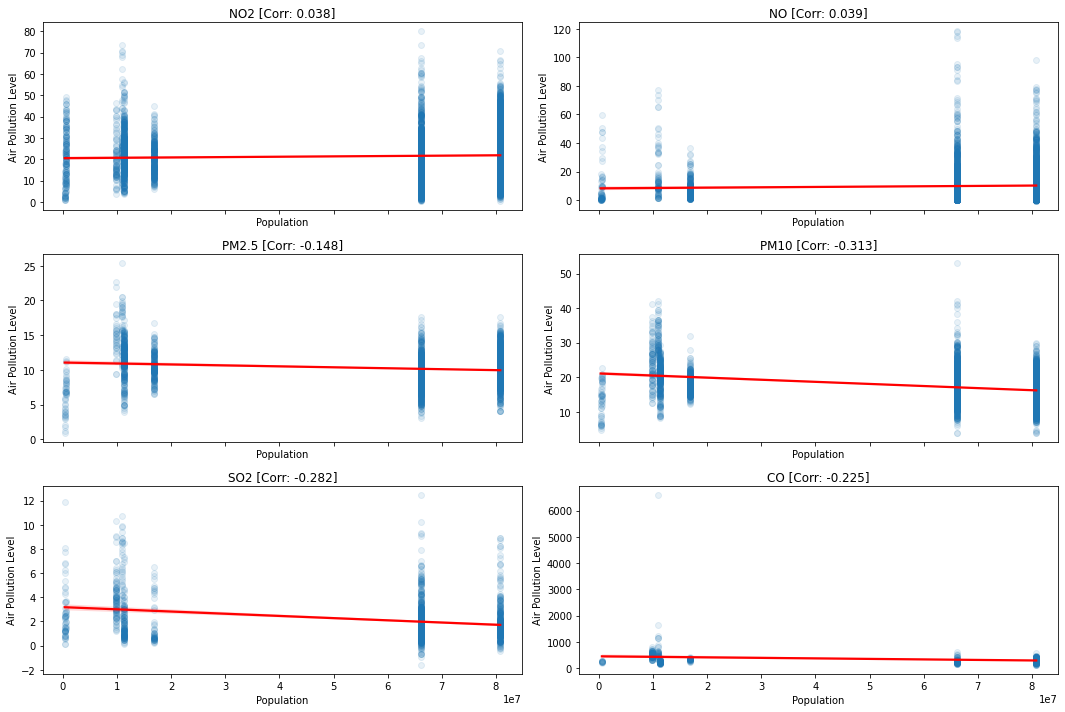

In [ ]:
fig, ax = plt.subplots(3, 2, tight_layout=True, figsize=(15,10), sharex=True)
clean_df = clean_df[clean_df['Year'] >= 2018]
for i, p in enumerate(clean_df['Air Pollutant'].unique()):
    clean_poll_df = clean_df[clean_df['Air Pollutant']==p]
    clean_poll_df = clean_poll_df.merge(country_df, on='Country')

    corr = np.corrcoef(clean_poll_df['Area'], clean_poll_df['Air Pollution Level'])
    sns.regplot(data=clean_poll_df, x='Area', y='Air Pollution Level',  ax=ax[i//2, i%2], scatter_kws={'alpha': 0.1}, line_kws={'color': 'red'})

    ax[i//2, i%2].set_title(f'{p} [Corr: {np.round(corr[0, 1], 3)}]')

fig, ax = plt.subplots(3, 2, tight_layout=True, figsize=(15,10), sharex=True)
clean_df = clean_df[clean_df['Year'] >= 2018]
for i, p in enumerate(clean_df['Air Pollutant'].unique()):
    clean_poll_df = clean_df[clean_df['Air Pollutant']==p]
    clean_poll_df = clean_poll_df.merge(country_df, on='Country')

    corr = np.corrcoef(clean_poll_df['City Population'], clean_poll_df['Air Pollution Level'])
    sns.regplot(data=clean_poll_df, x='City Population', y='Air Pollution Level',  ax=ax[i//2, i%2], scatter_kws={'alpha': 0.1}, line_kws={'color': 'red'})

    ax[i//2, i%2].set_title(f'{p} [Corr: {np.round(corr[0, 1], 3)}]')

fig, ax = plt.subplots(3, 2, tight_layout=True, figsize=(15,10), sharex=True)
clean_df = clean_df[clean_df['Year'] >= 2018]
for i, p in enumerate(clean_df['Air Pollutant'].unique()):
    clean_poll_df = clean_df[clean_df['Air Pollutant']==p]
    clean_poll_df = clean_poll_df.merge(country_df, on='Country')

    corr = np.corrcoef(clean_poll_df['Population'], clean_poll_df['Air Pollution Level'])
    sns.regplot(data=clean_poll_df, x='Population', y='Air Pollution Level',  ax=ax[i//2, i%2], scatter_kws={'alpha': 0.1}, line_kws={'color': 'red'})

    ax[i//2, i%2].set_title(f'{p} [Corr: {np.round(corr[0, 1], 3)}]')

Looking at the regression models and the correlation coefficients, we see that there is very little correlation between the size of a country and its pollution levels.

# Q.3 Do the regulations introduced by the European Commission change anything compared to other countries?
## First, let's analyze potential trends in the air quality data over the years for each country individually. Let's see if this got sort of "flattened" after the regulations have been added.

Let's now convert the data to obtain the average air pollution, by pollutant, by country and by year.

In [11]:
poll_df = poll_df.groupby(by=['Country', 'Air Pollutant', 'Year']).agg({'Air Pollution Level': 'mean'})
poll_df

Air Pollution Level
Country     Air Pollutant Year                     
Belgium     CO            1994          1001.500000
                          1995           981.500000
                          1996           866.500000
                          1997           727.666667
                          1998           569.250000
...                                             ...
Netherlands SO2           2019             1.817286
                          2020             1.549786
                          2021             1.699571
                          2022             1.583200
                          2023             1.164800

[1025 rows x 1 columns]

In [12]:
poll_df = poll_df.reset_index()

Let's now plot what these concentrations look like over the years in each country individually.

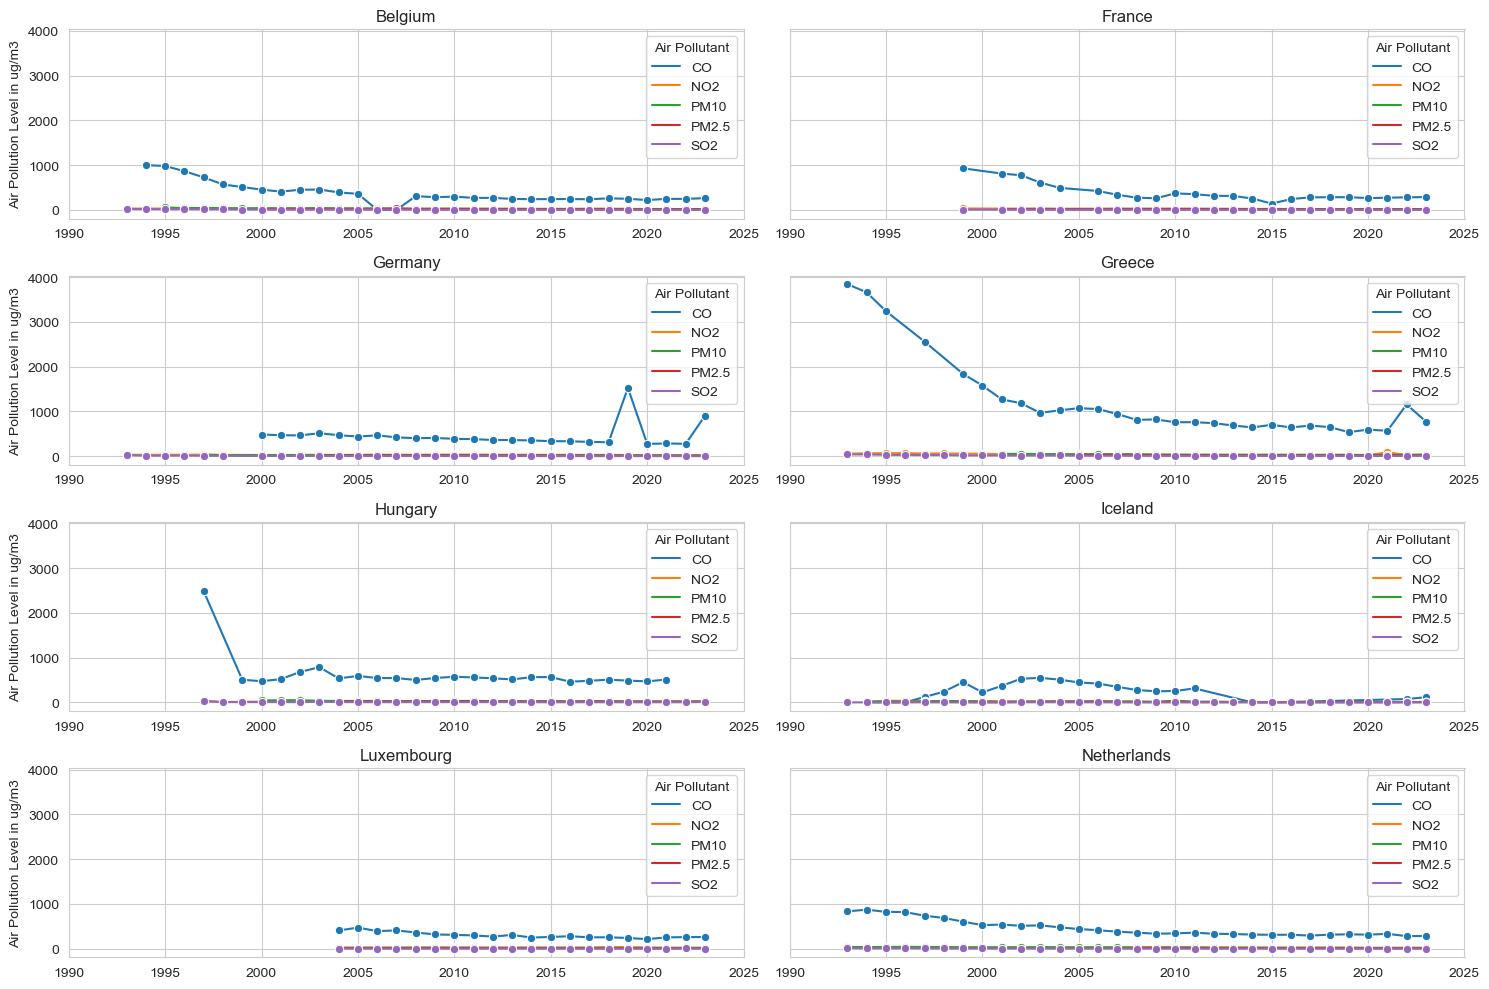

In [13]:
fig, ax = plt.subplots(4, 2, tight_layout=True, figsize=(15, 10), sharey=True)
pos_x, pos_y = 0, 0
for x in poll_df['Country'].unique():
    temp = poll_df.loc[poll_df['Country'] == x]
    sns.lineplot(temp, x='Year', y='Air Pollution Level', hue='Air Pollutant', ax=ax[pos_x, pos_y], marker='o')
    ax[pos_x, pos_y].set_xticks(np.arange(1990, 2030, 5))
    ax[pos_x, pos_y].set_title(x)
    ax[pos_x, pos_y].set_xlabel("")
    ax[pos_x, pos_y].set_ylabel('Air Pollution Level in ug/m3')
    pos_y += 1
    if pos_y == 2:
        pos_x += 1
        pos_y = 0

plt.show()

This is hard to read, so we will make two plots, one for each pollutant.

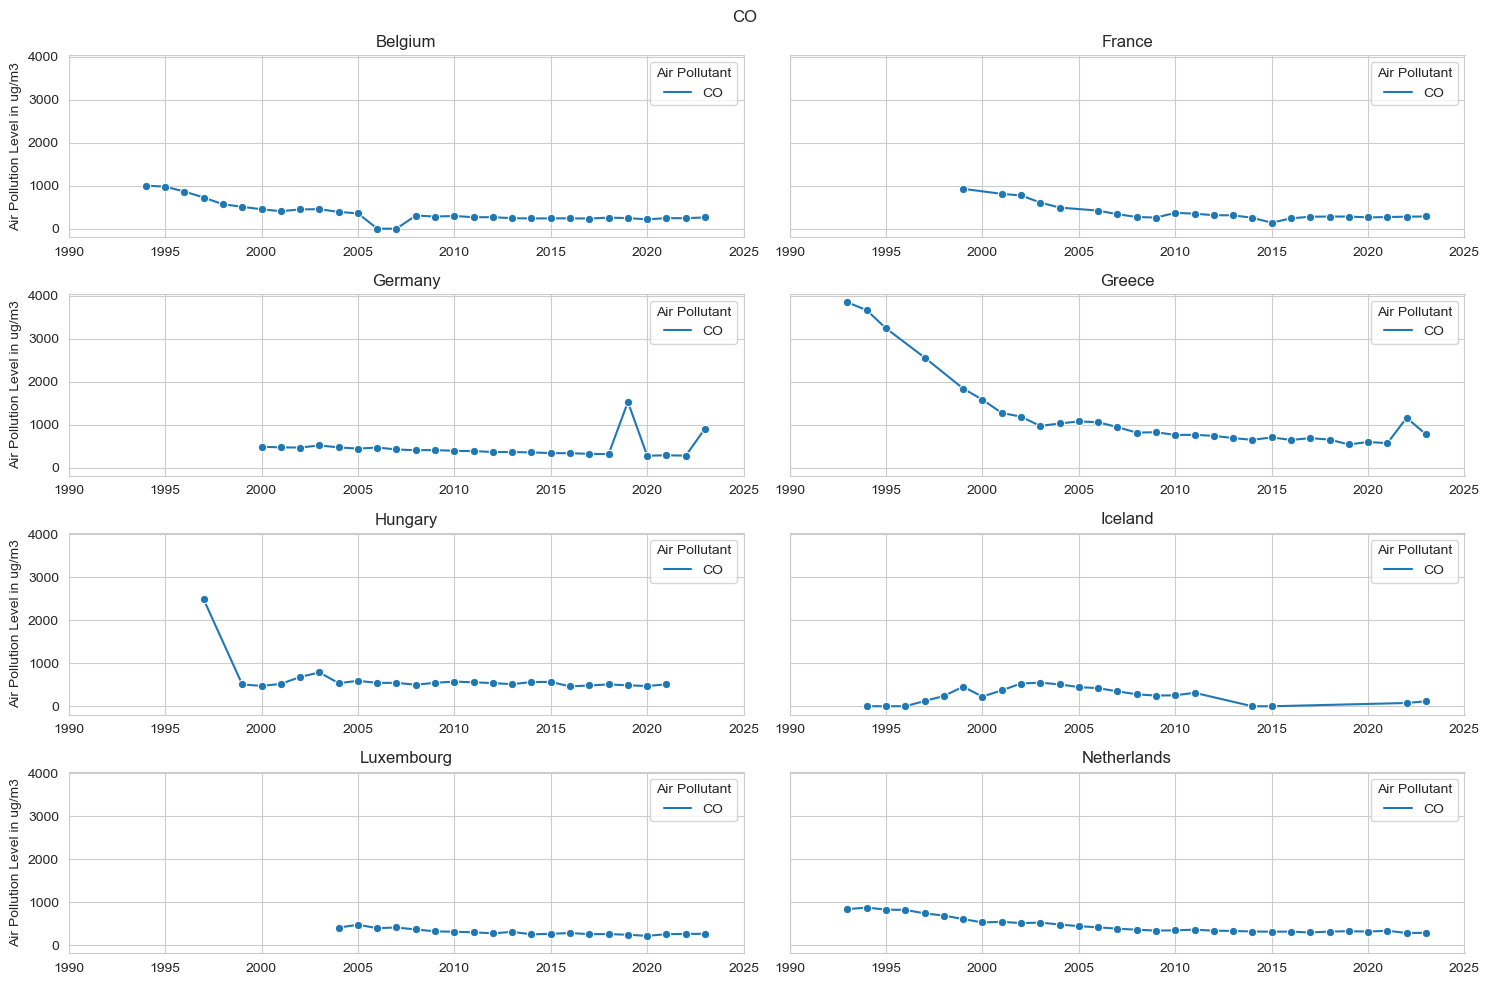

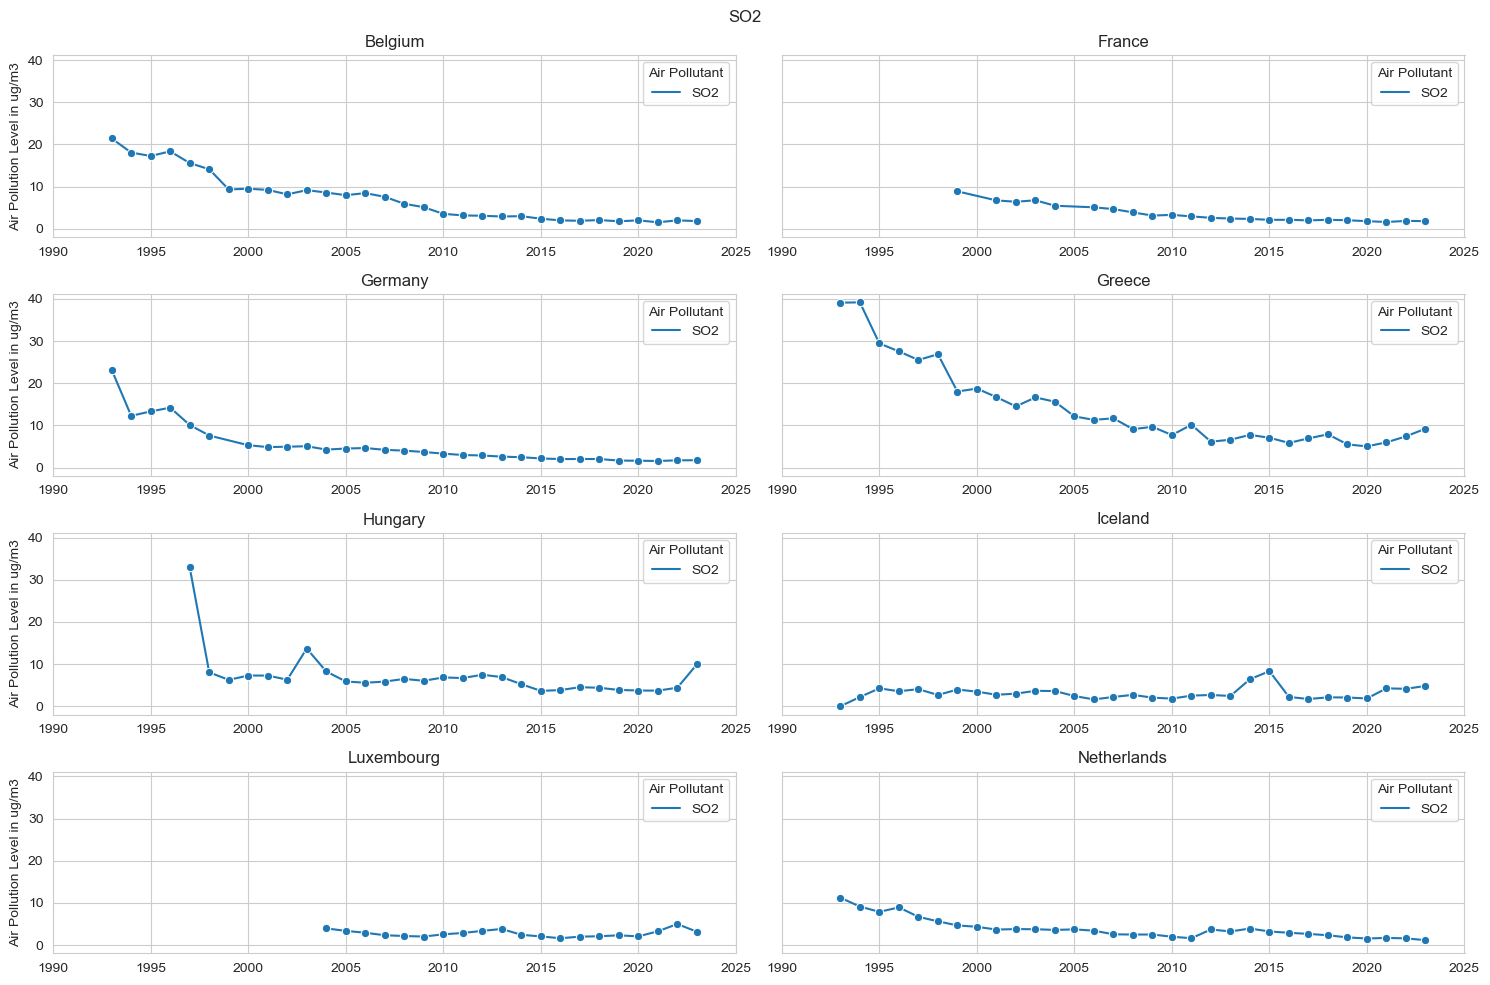

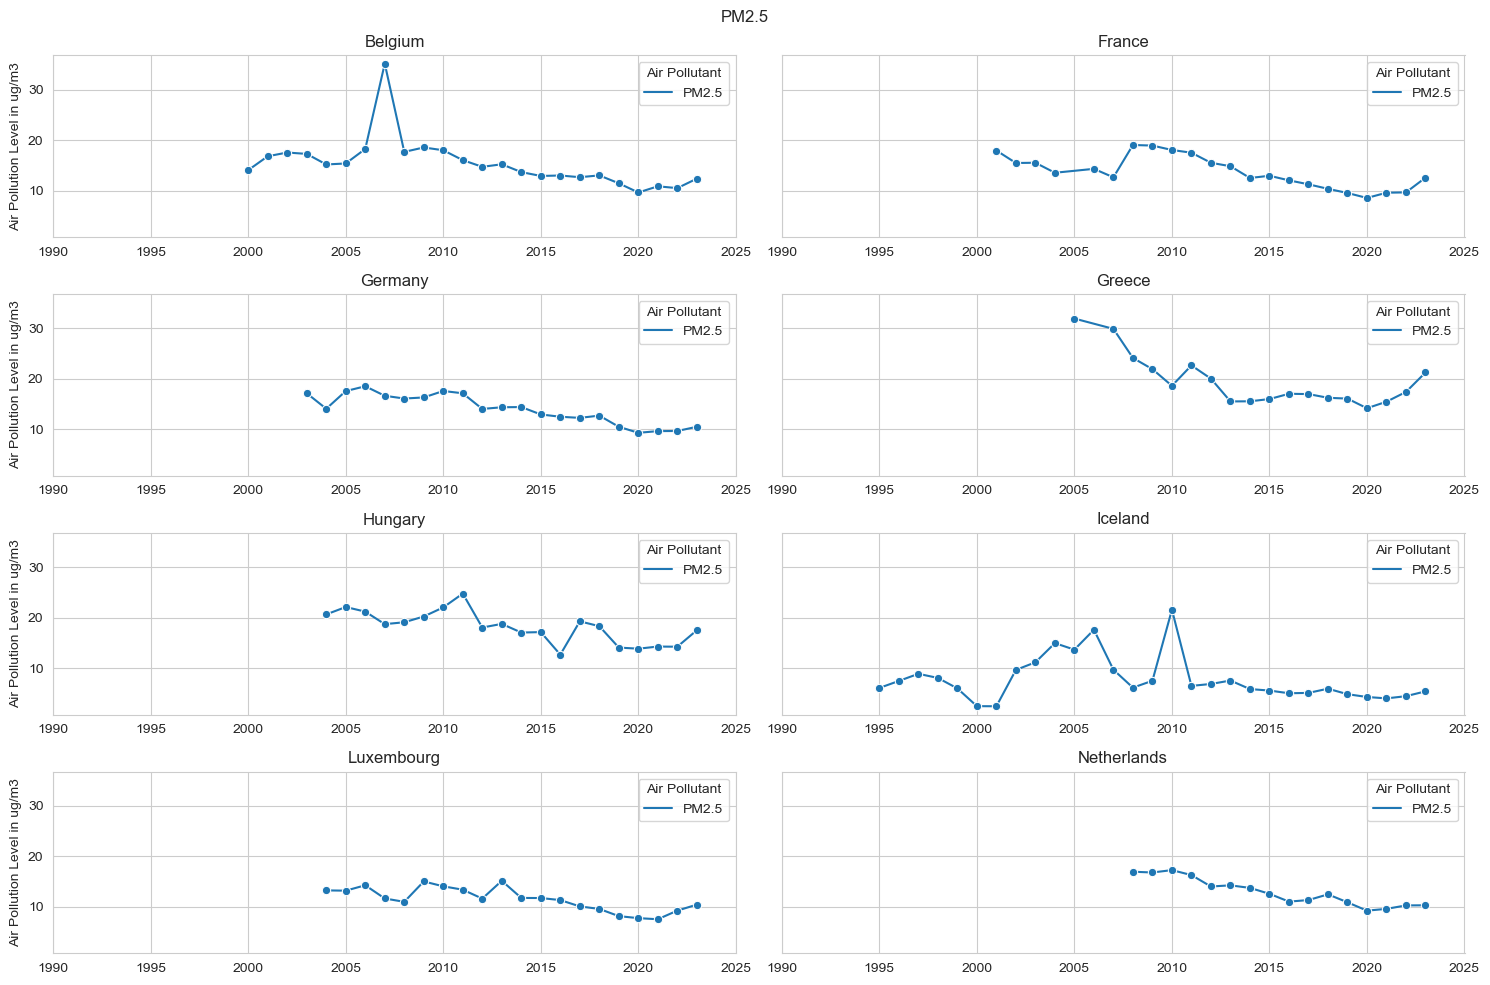

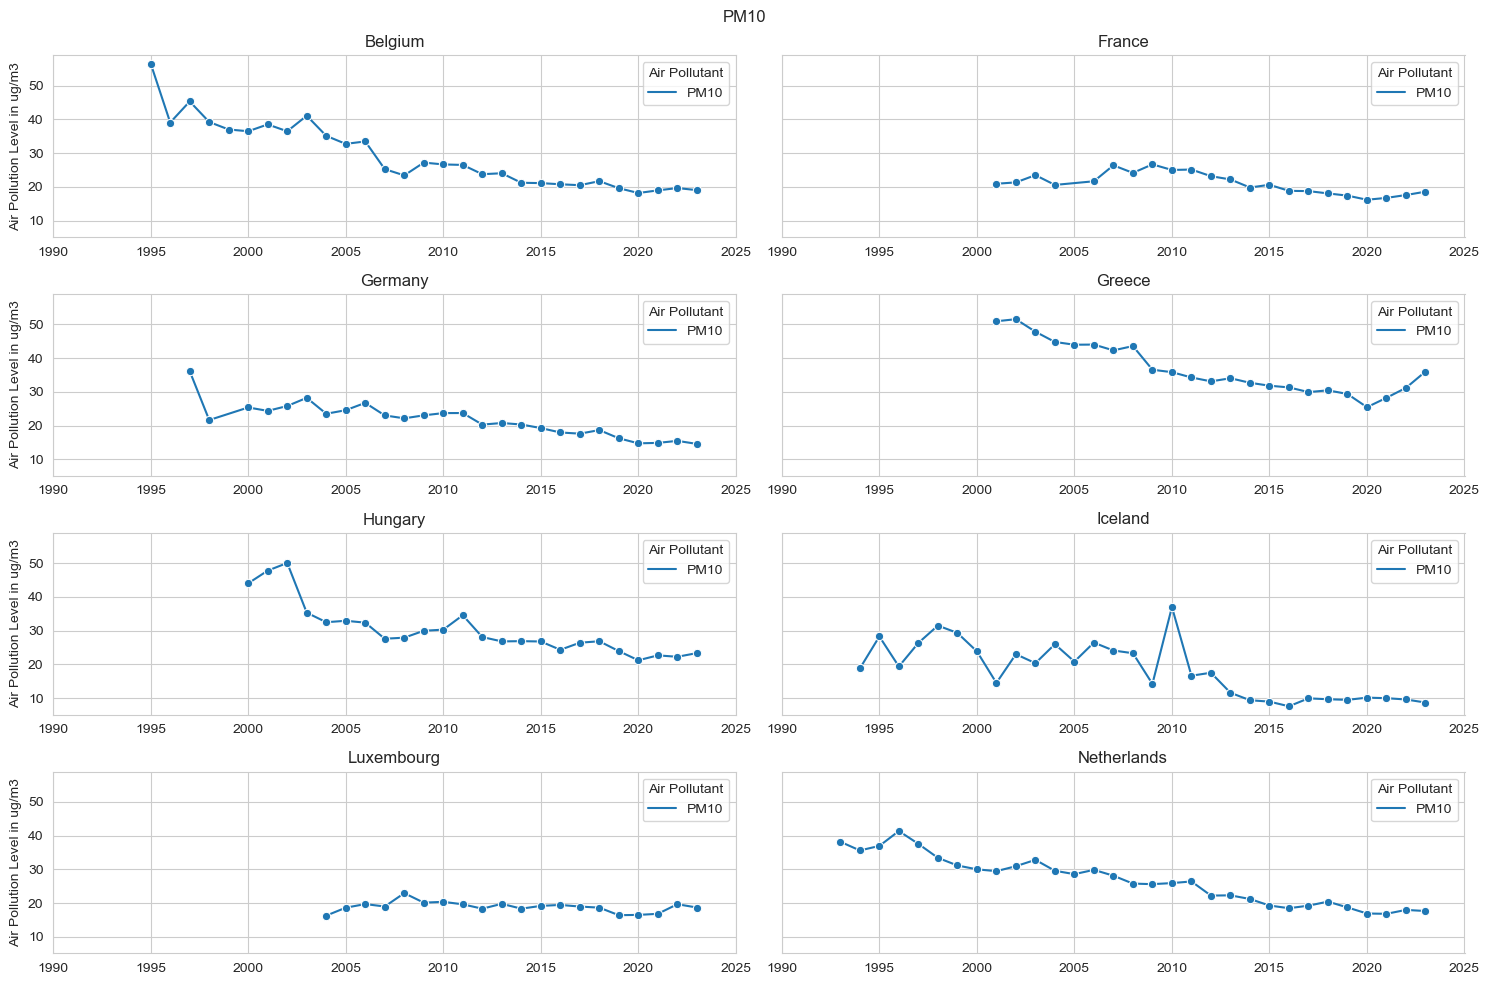

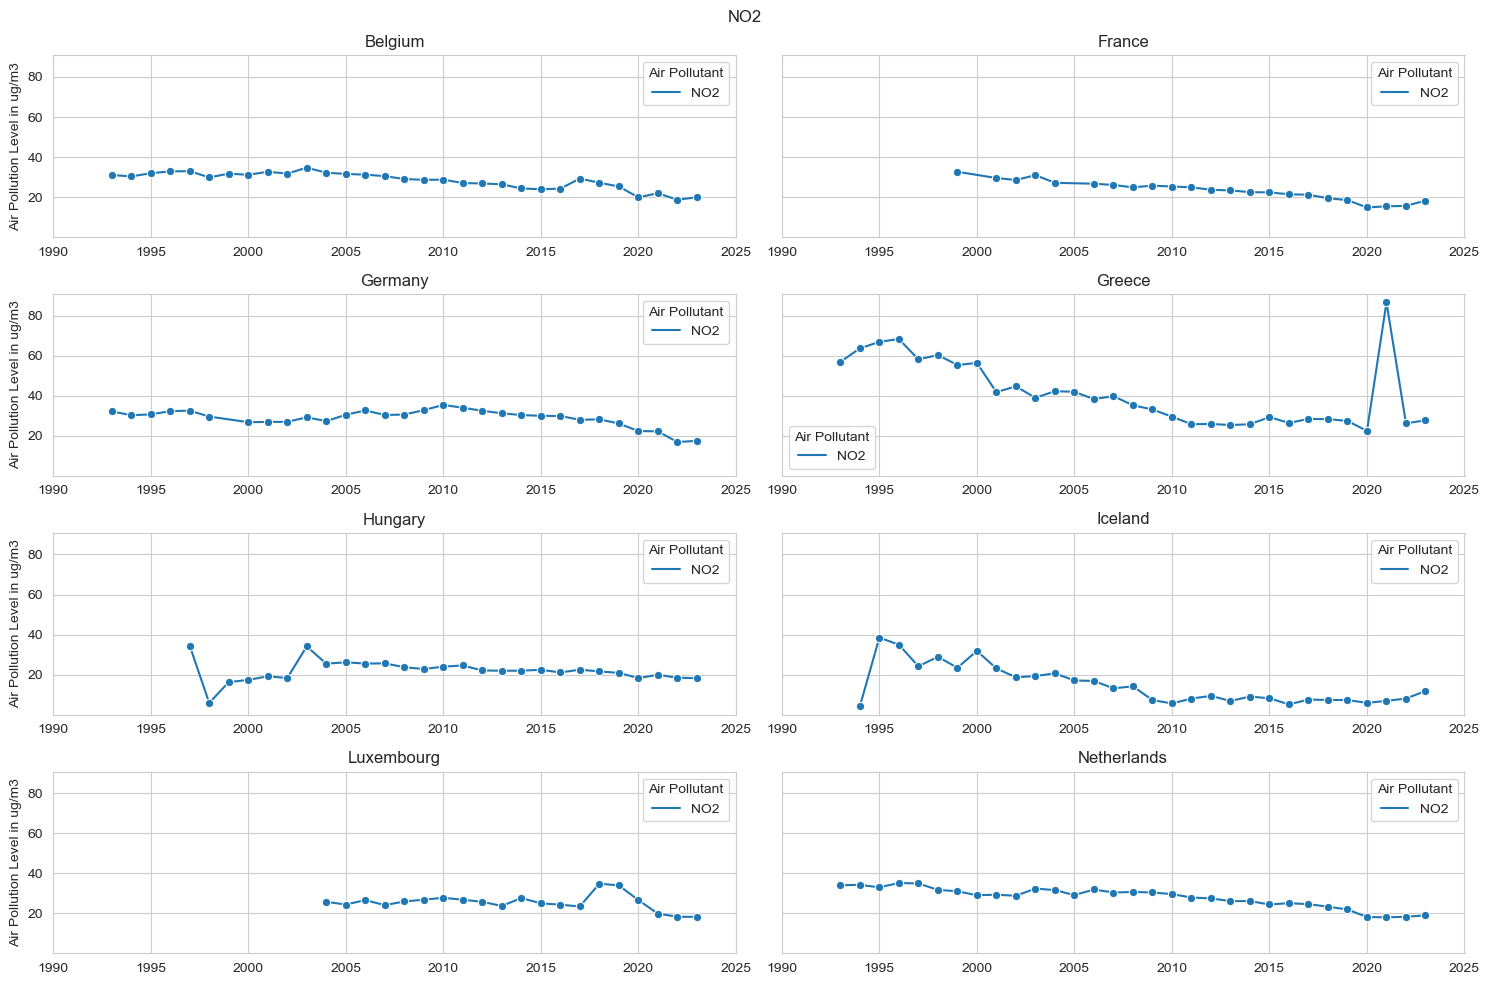

In [14]:
for p in pollutants:
    fig, ax = plt.subplots(4, 2, tight_layout=True, figsize=(15, 10), sharey=True)
    pos_x, pos_y = 0, 0
    for x in poll_df['Country'].unique():
        temp = poll_df.loc[(poll_df['Country'] == x) & (poll_df['Air Pollutant'] == p)]
        sns.lineplot(temp, x='Year', y='Air Pollution Level', hue='Air Pollutant', ax=ax[pos_x, pos_y], marker='o')
        ax[pos_x, pos_y].set_xticks(np.arange(1990, 2030, 5))
        ax[pos_x, pos_y].set_title(x)
        ax[pos_x, pos_y].set_xlabel("")
        ax[pos_x, pos_y].set_ylabel('Air Pollution Level in ug/m3')
        pos_y += 1
        if pos_y == 2:
            pos_x += 1
            pos_y = 0

    plt.suptitle(p)
    plt.show()

We can notice that the pollution in the air stayed quite steady over the years in Europe. However, for some countries we can see a tendency of increasing quantity of SO2 in the atmosphere.

## Next, we will use this data to perform regression on it. Two models will be considered: simple linear regression and ARIMA. We will then evaluate which method is more likely to predict better results. This will help us determine whether further regulations should be added in the future.

The models will be defined as follows: they will be trained on data from 2010 through 2020 and tested on data from 2021 through 2023. This, for each country individually as trends are assumed to be country-specific. Then, using the fit model, we will make an approximation up to 5 years ahead for the quantity of each pollutant estimated to be observed in each country.

Let's define testing and training data

In [15]:
from sklearn.metrics import mean_squared_error, r2_score

def get_training_and_testing_data(data, pollutant, country):
    temp = data.loc[(data['Air Pollutant'] == pollutant) & (data['Country'] == country)]

    X_train = temp.loc[temp['Year'].isin(range(0, 2021)), 'Year'].values.reshape(-1, 1)
    y_train = temp.loc[temp['Year'].isin(range(0, 2021)), 'Air Pollution Level'].values.reshape(-1, 1)

    X_test = temp.loc[temp['Year'].isin(range(2021, 2024)), 'Year'].values.reshape(-1, 1)
    y_test = temp.loc[temp['Year'].isin(range(2021, 2024)), 'Air Pollution Level'].values.reshape(-1, 1)

    return X_train, y_train, X_test, y_test

def compute_errors(y_train, y_train_hat, y_test, y_pred):
    return [
        mean_squared_error(y_train, y_train_hat),
        r2_score(y_train, y_train_hat),
        mean_squared_error(y_test, y_pred),
        r2_score(y_test, y_pred)
    ]

### Linear Regression

Let's first determine the accuracy of the model for each country and pollutant.

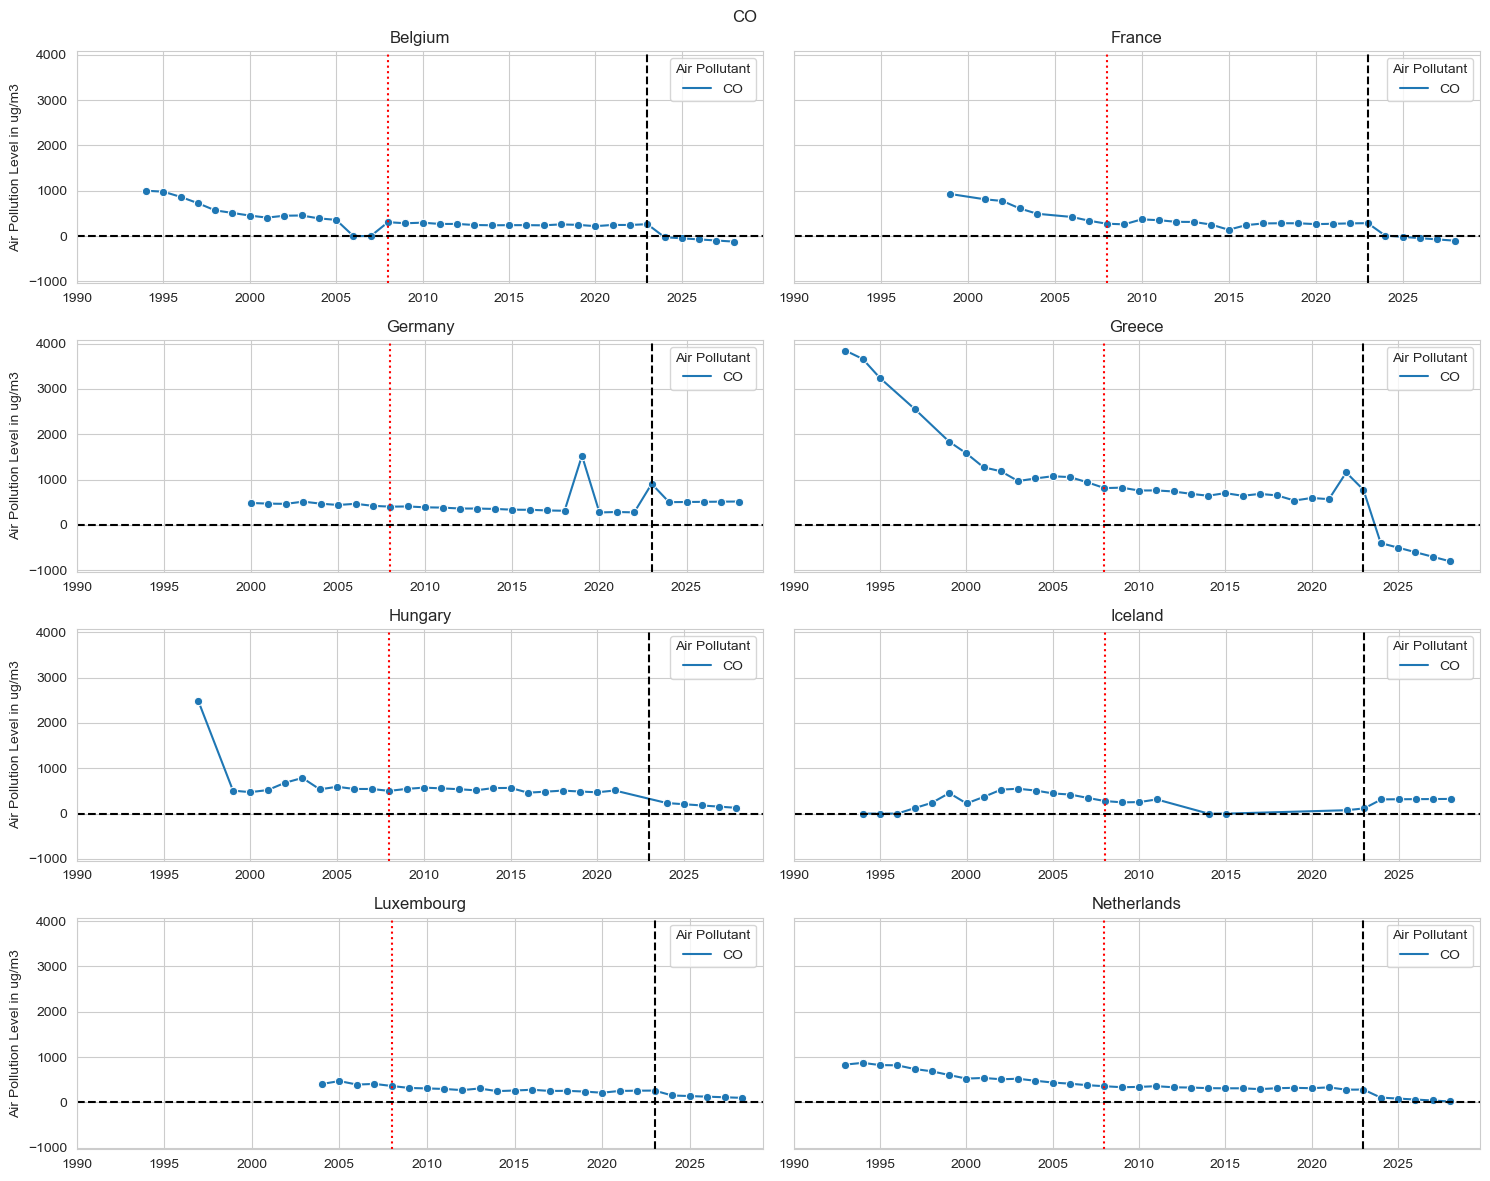

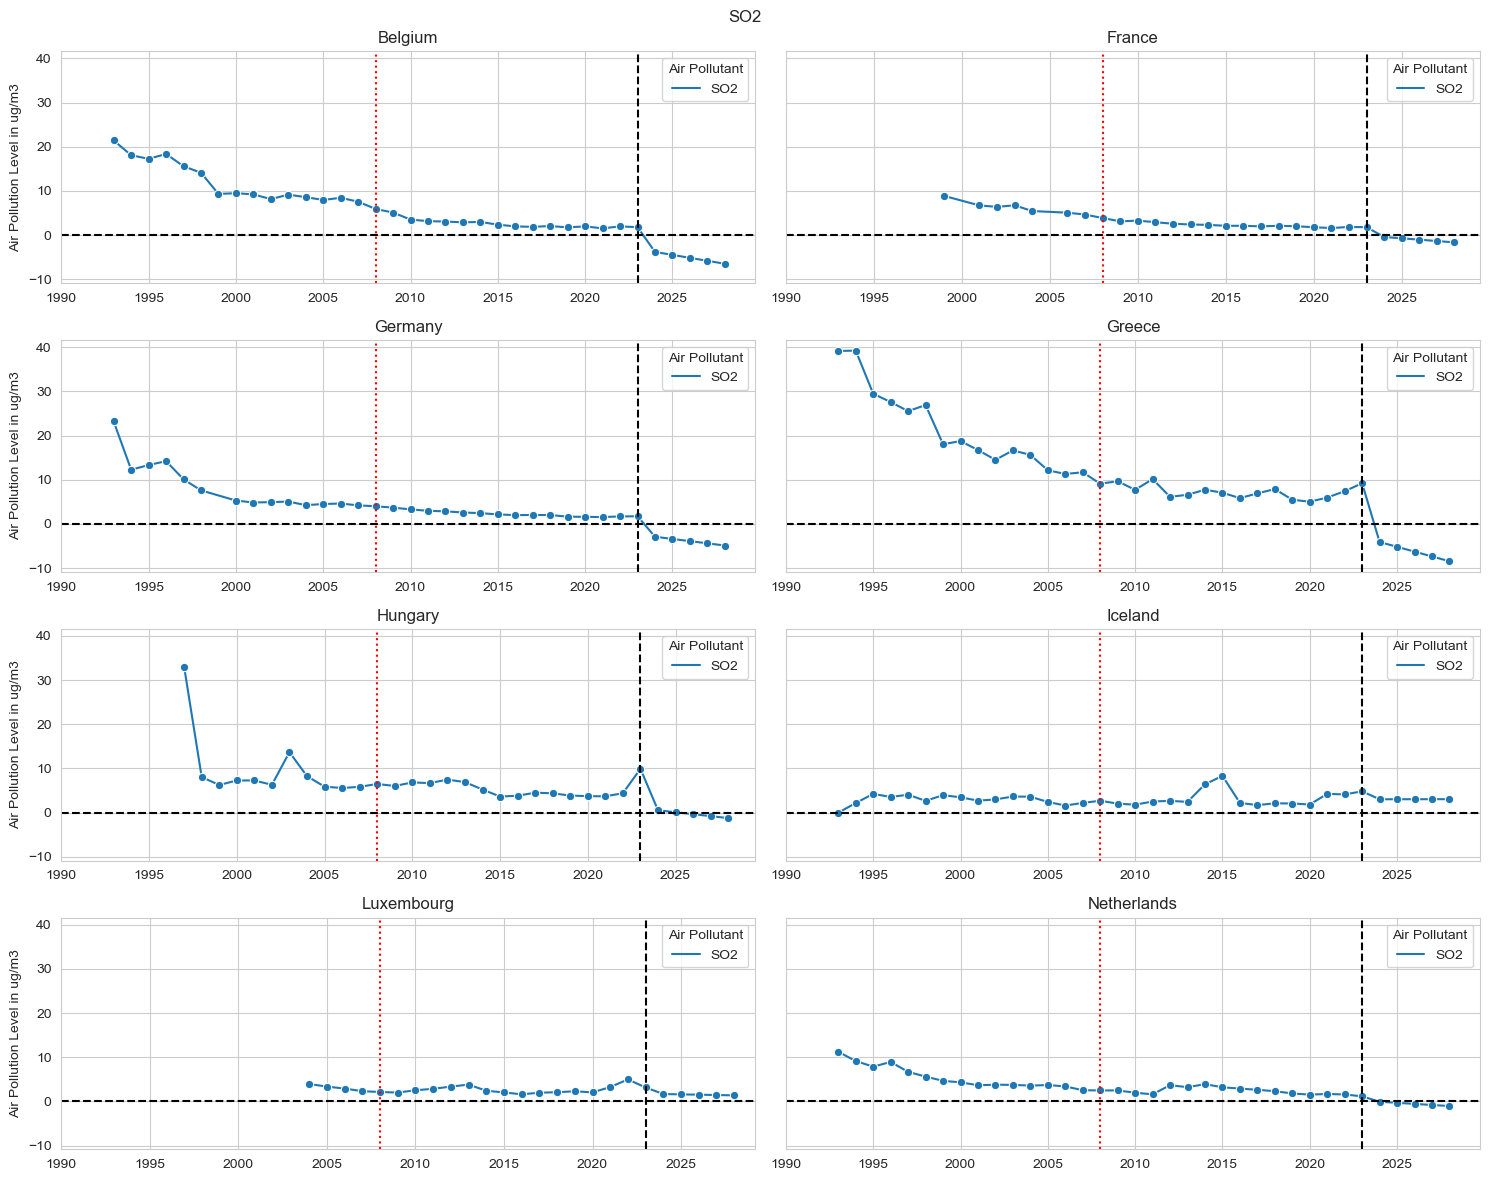

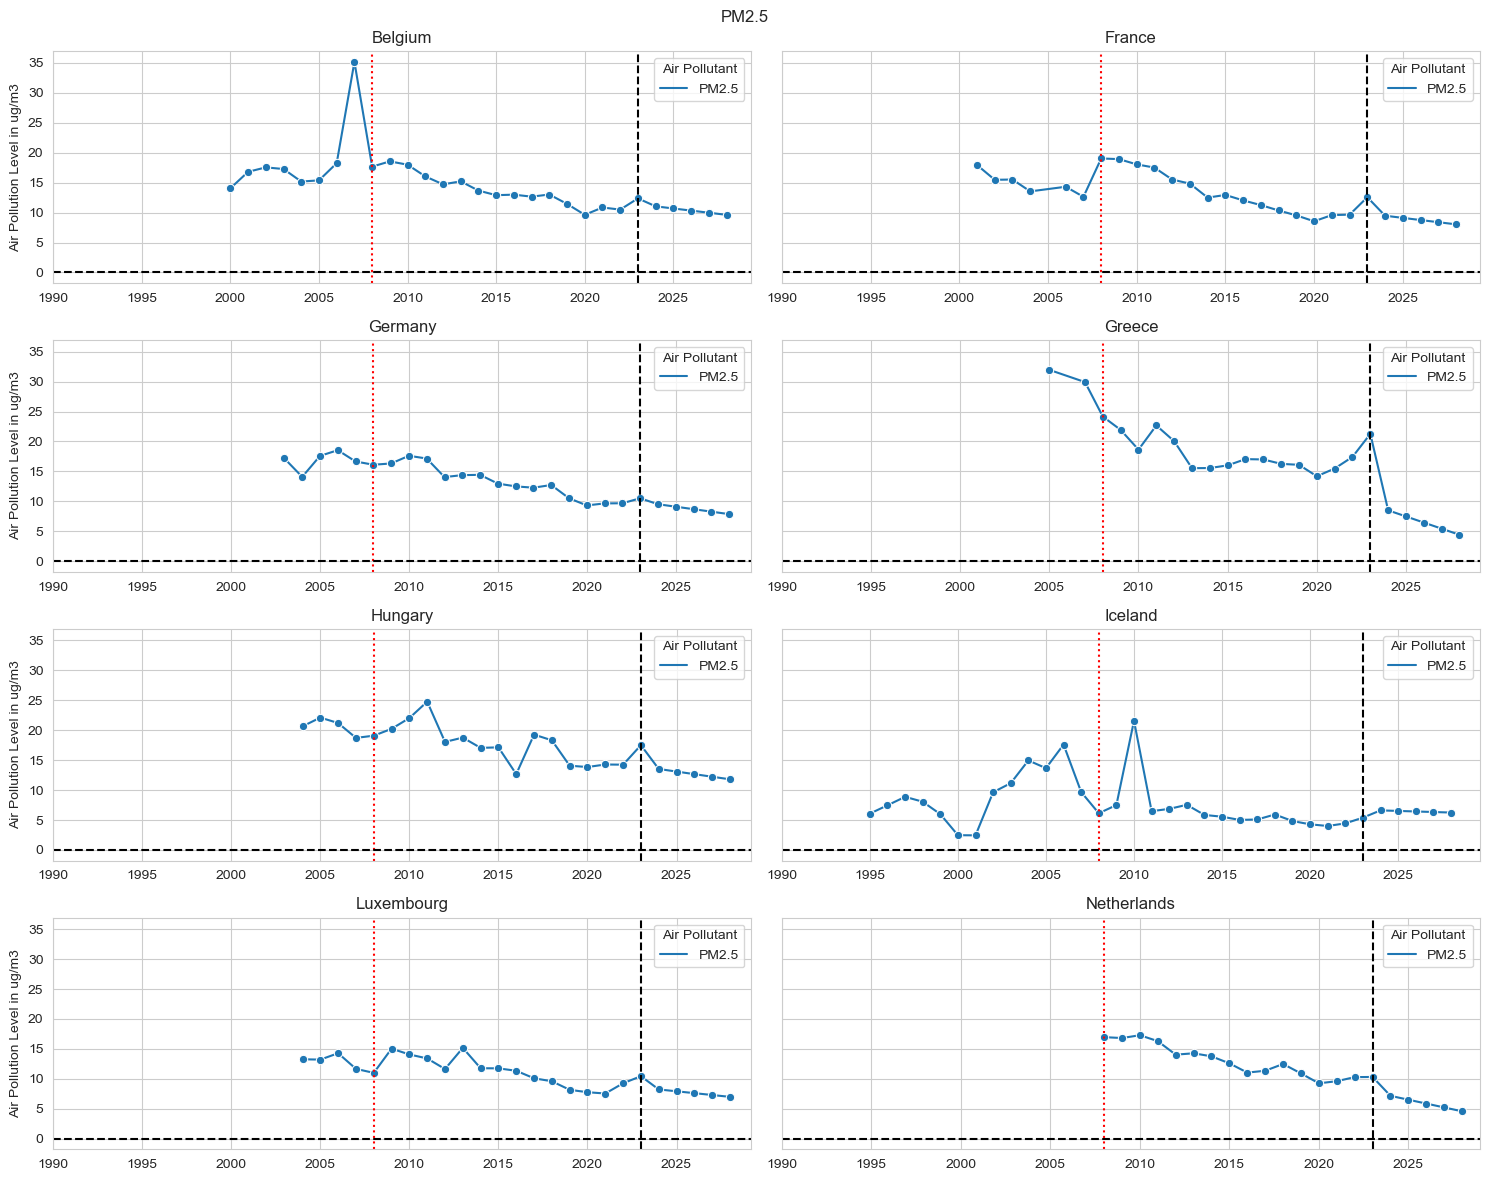

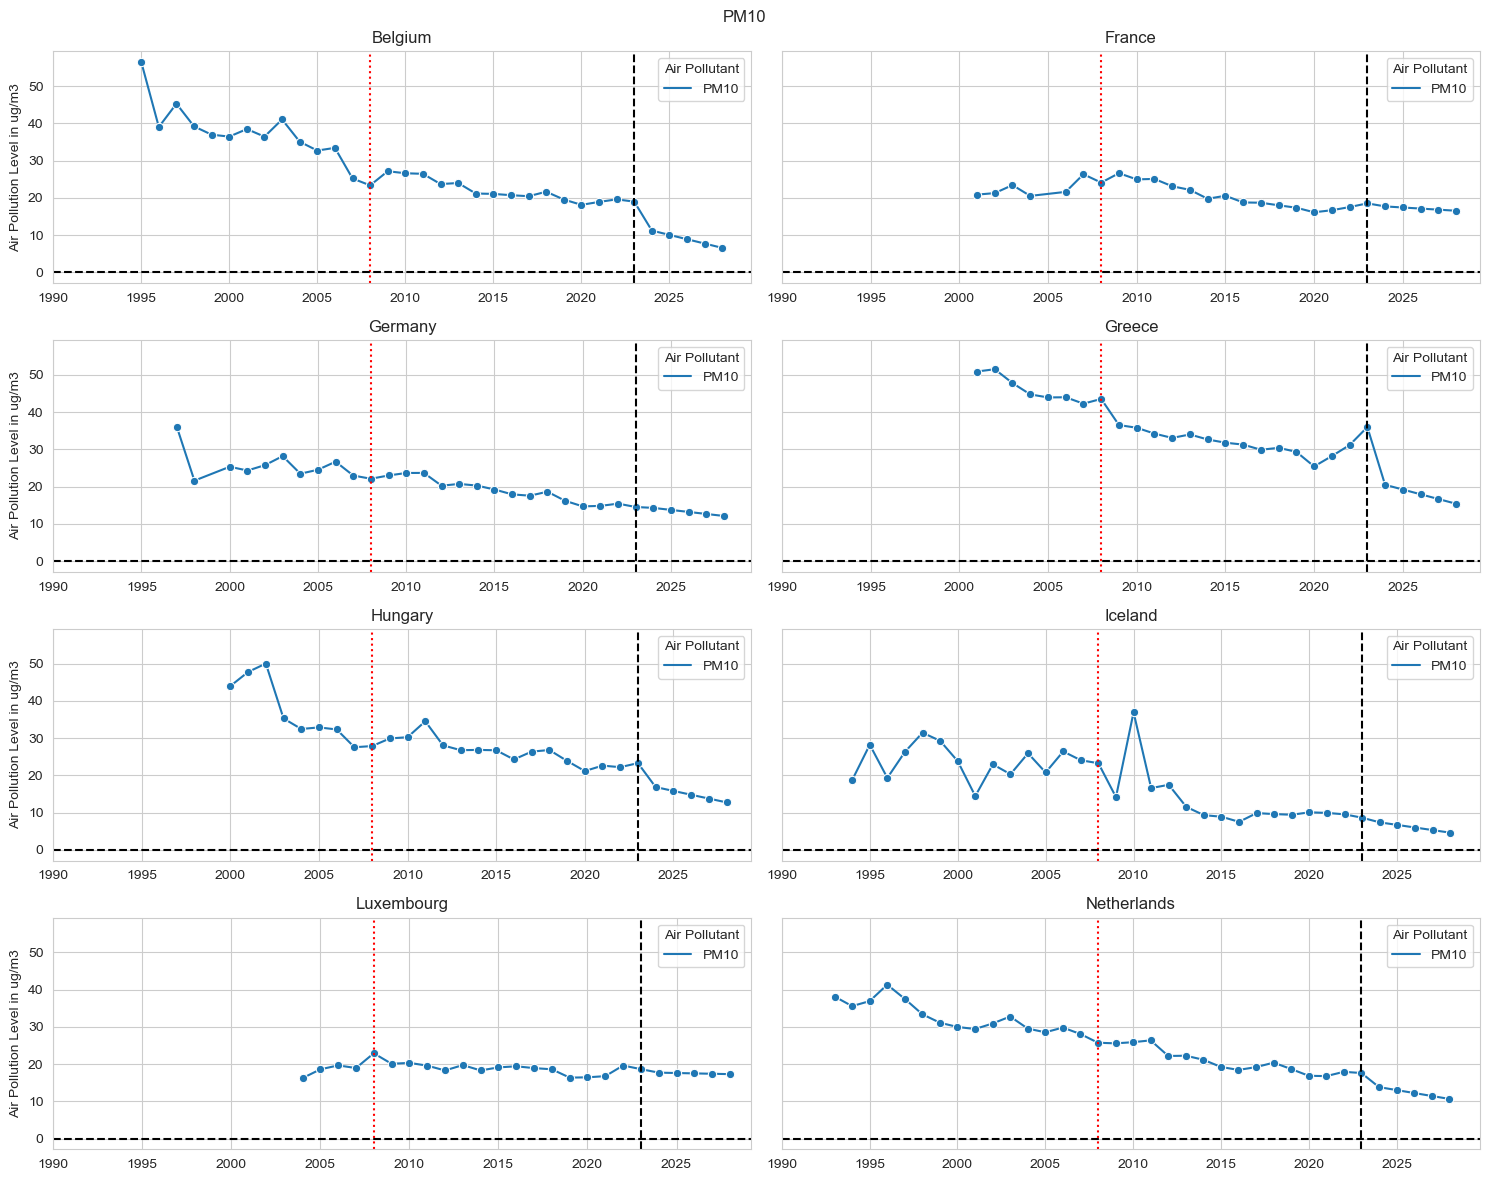

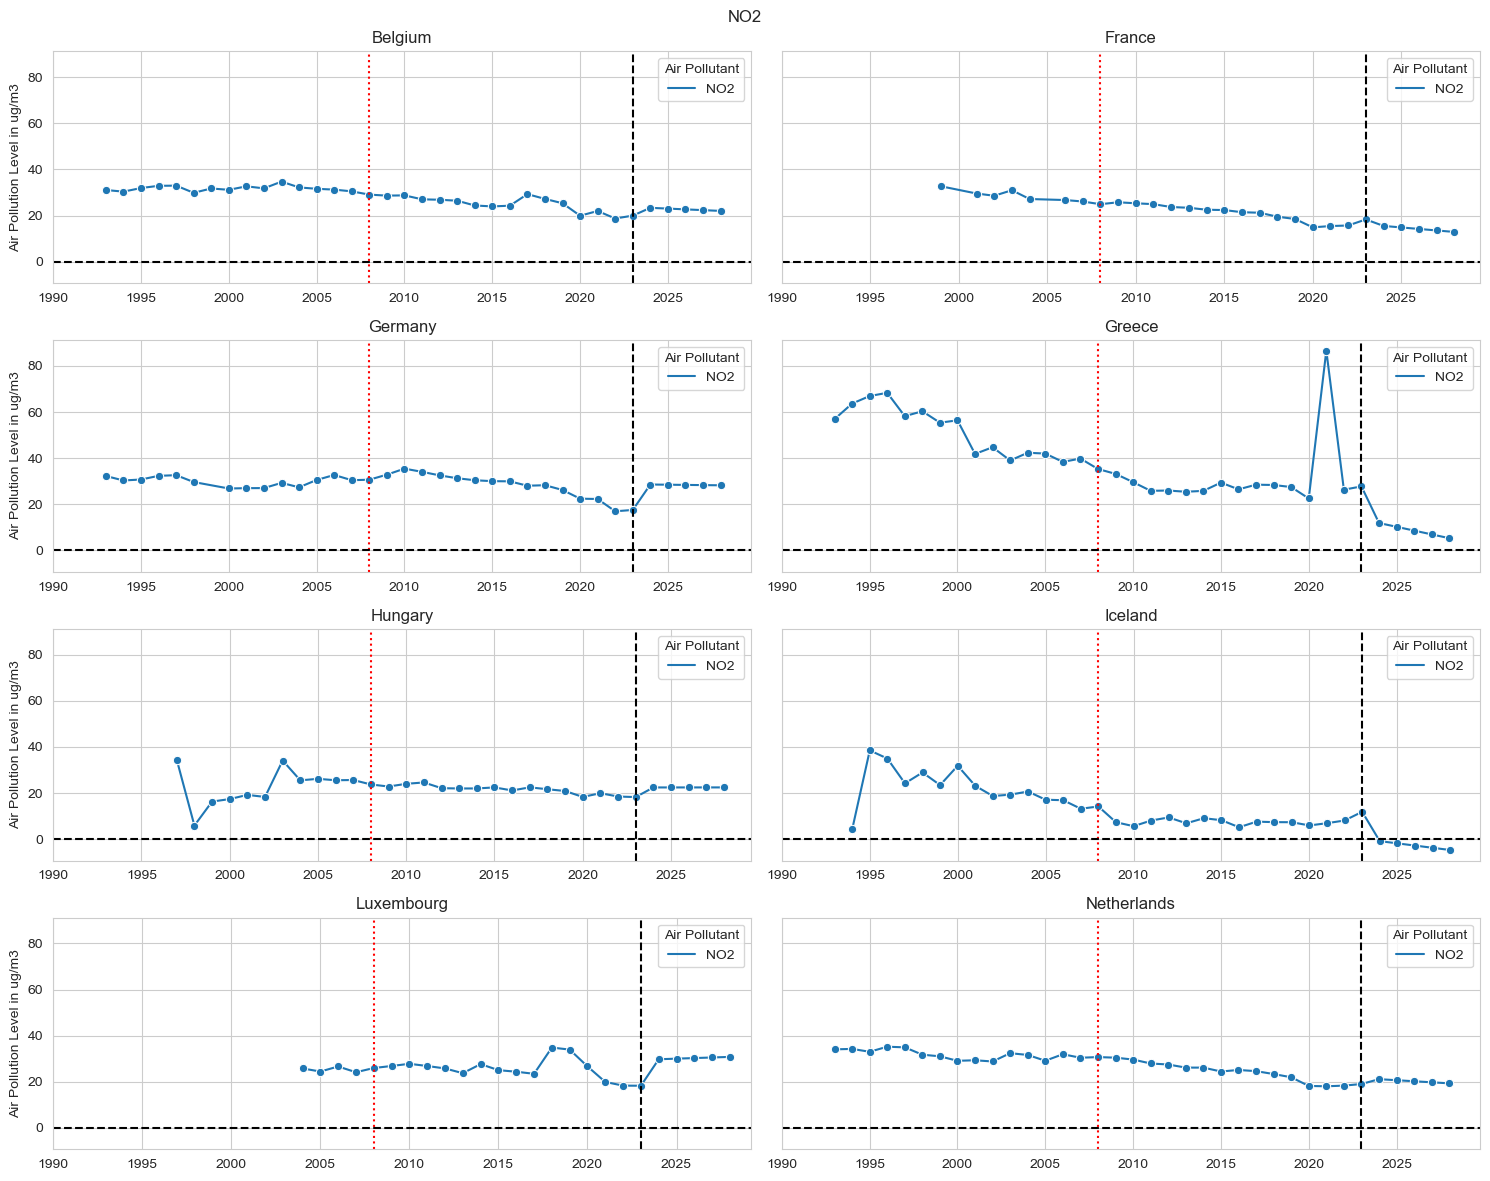

In [16]:
model = LinearRegression()

forecast = poll_df.copy().reset_index(drop=True)
lg_errors = pd.DataFrame(
    columns=['Country', 'Air Pollutant', 'Training MSE', 'Training R^2', 'Testing MSE', 'Testing R^2']
)

for p in pollutants:
    fig, ax = plt.subplots(4, 2, tight_layout=True, figsize=(15, 12), sharey=True)
    pos_x, pos_y = 0, 0
    for x in poll_df['Country'].unique():
        X_train, y_train, X_test, y_test = get_training_and_testing_data(data=poll_df, pollutant=p, country=x)

        # Compute training and testing error of the model
        model_fit = model.fit(X_train, y_train)
        y_train_hat = model_fit.predict(X_train)
        y_pred = model_fit.predict(X_test)
        lg_errors.loc[len(lg_errors.index)] = [x, p] + compute_errors(y_train, y_train_hat, y_test, y_pred)

        # Forecast
        X_forecast = [[2024], [2025], [2026], [2027], [2028]]
        y_forecast = model_fit.predict(X_forecast)
        for i, y in enumerate(y_forecast):
            forecast.loc[len(forecast.index), :] = [x, p, X_forecast[i][0], y[0]]

        # Plot the forecast
        temp = forecast.loc[(forecast['Country'] == x) & (forecast['Air Pollutant'] == p)]
        sns.lineplot(temp, x='Year', y='Air Pollution Level', hue='Air Pollutant', ax=ax[pos_x, pos_y], marker='o')
        ax[pos_x, pos_y].axvline(x=2008, color='r', linestyle=':')
        ax[pos_x, pos_y].axvline(x=2023, color='k', linestyle='--')
        ax[pos_x, pos_y].axhline(y=0, color='k', linestyle='--')
        ax[pos_x, pos_y].set_xticks(np.arange(1990, 2030, 5))
        ax[pos_x, pos_y].set_title(x)
        ax[pos_x, pos_y].set_xlabel("")
        ax[pos_x, pos_y].set_ylabel('Air Pollution Level in ug/m3')
        pos_y += 1
        if pos_y == 2:
            pos_x += 1
            pos_y = 0

    plt.suptitle(p)
    plt.show()

lg_errors = lg_errors.groupby(['Country', 'Air Pollutant']).mean()
lg_errors.columns = pd.MultiIndex.from_arrays([['Training', 'Training', 'Testing', 'Testing'],
                                            ['MSE', 'R^2', 'MSE', 'R^2']])

### ARIMA

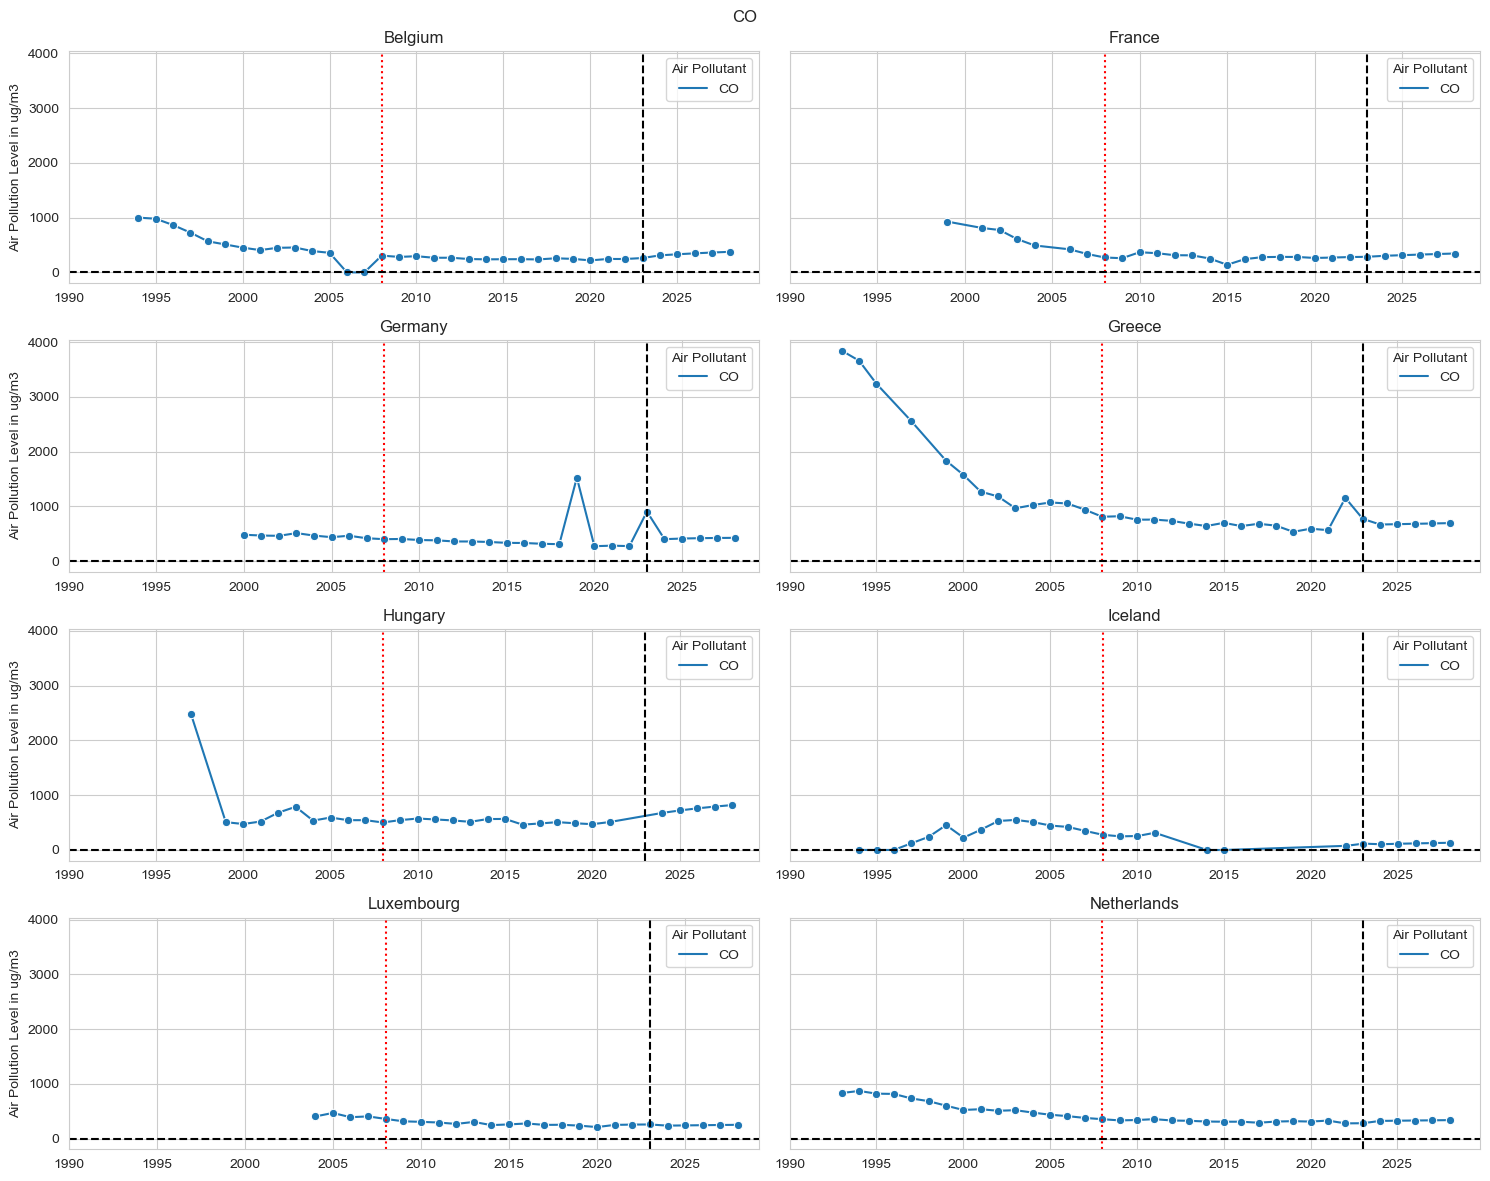

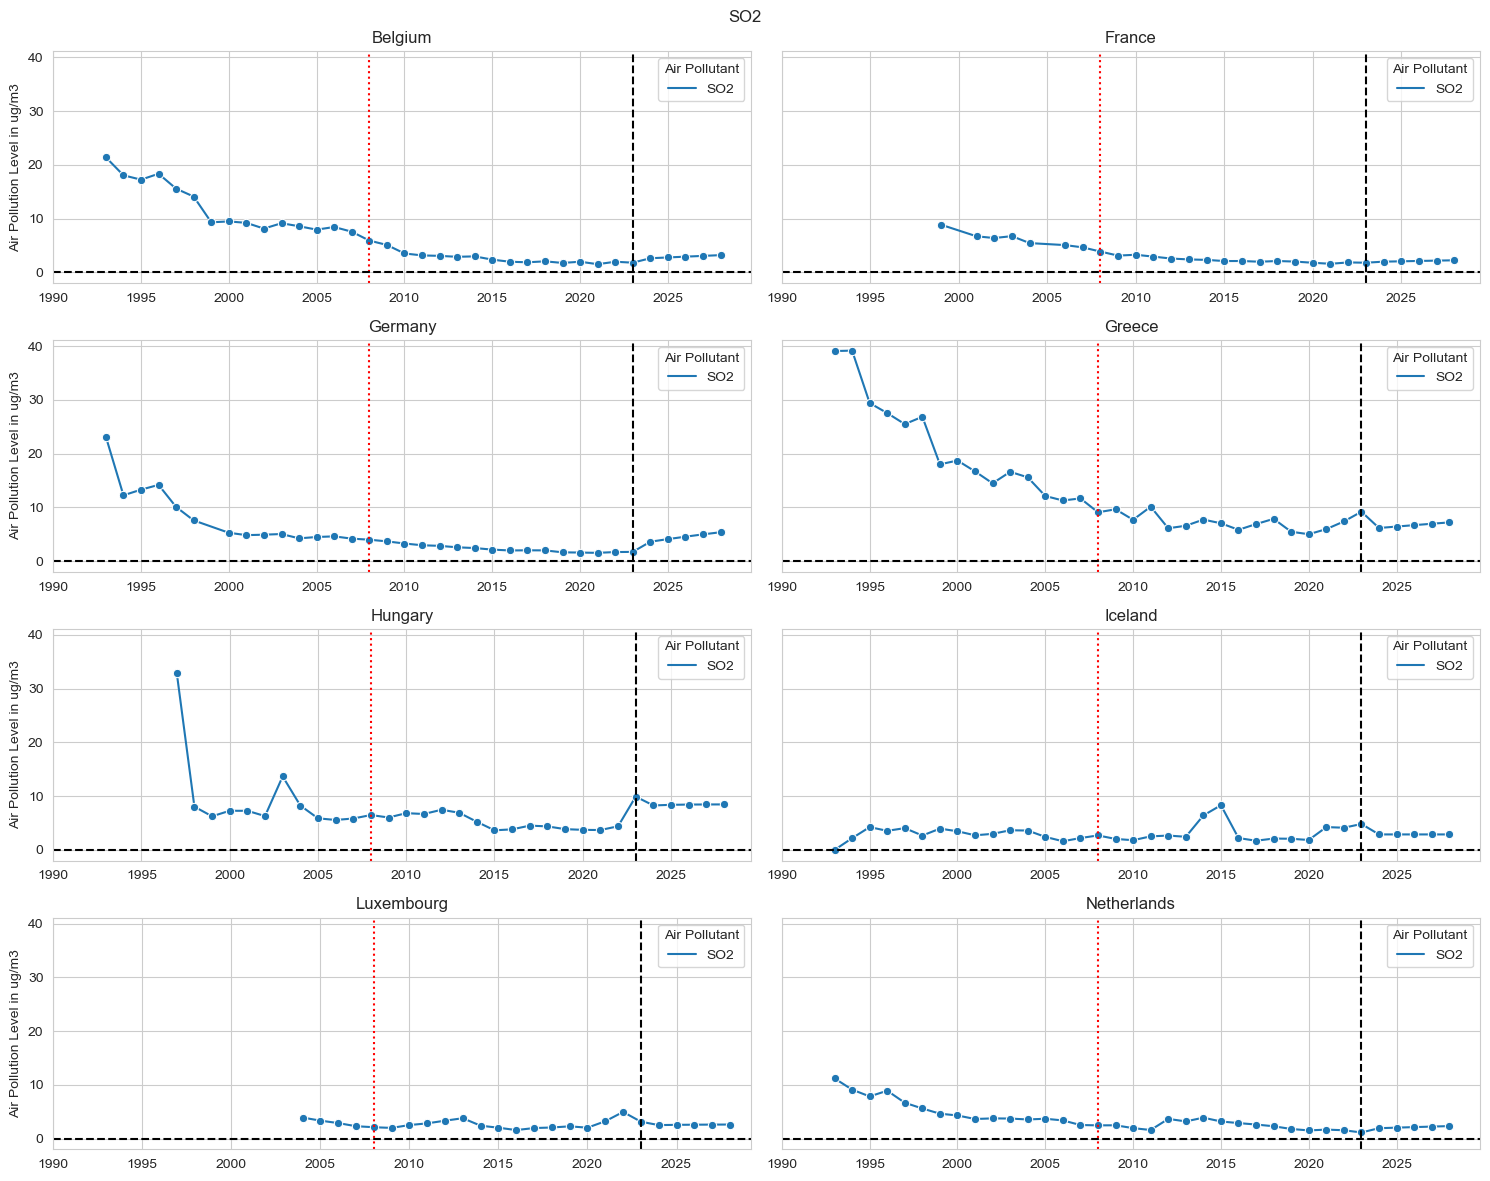

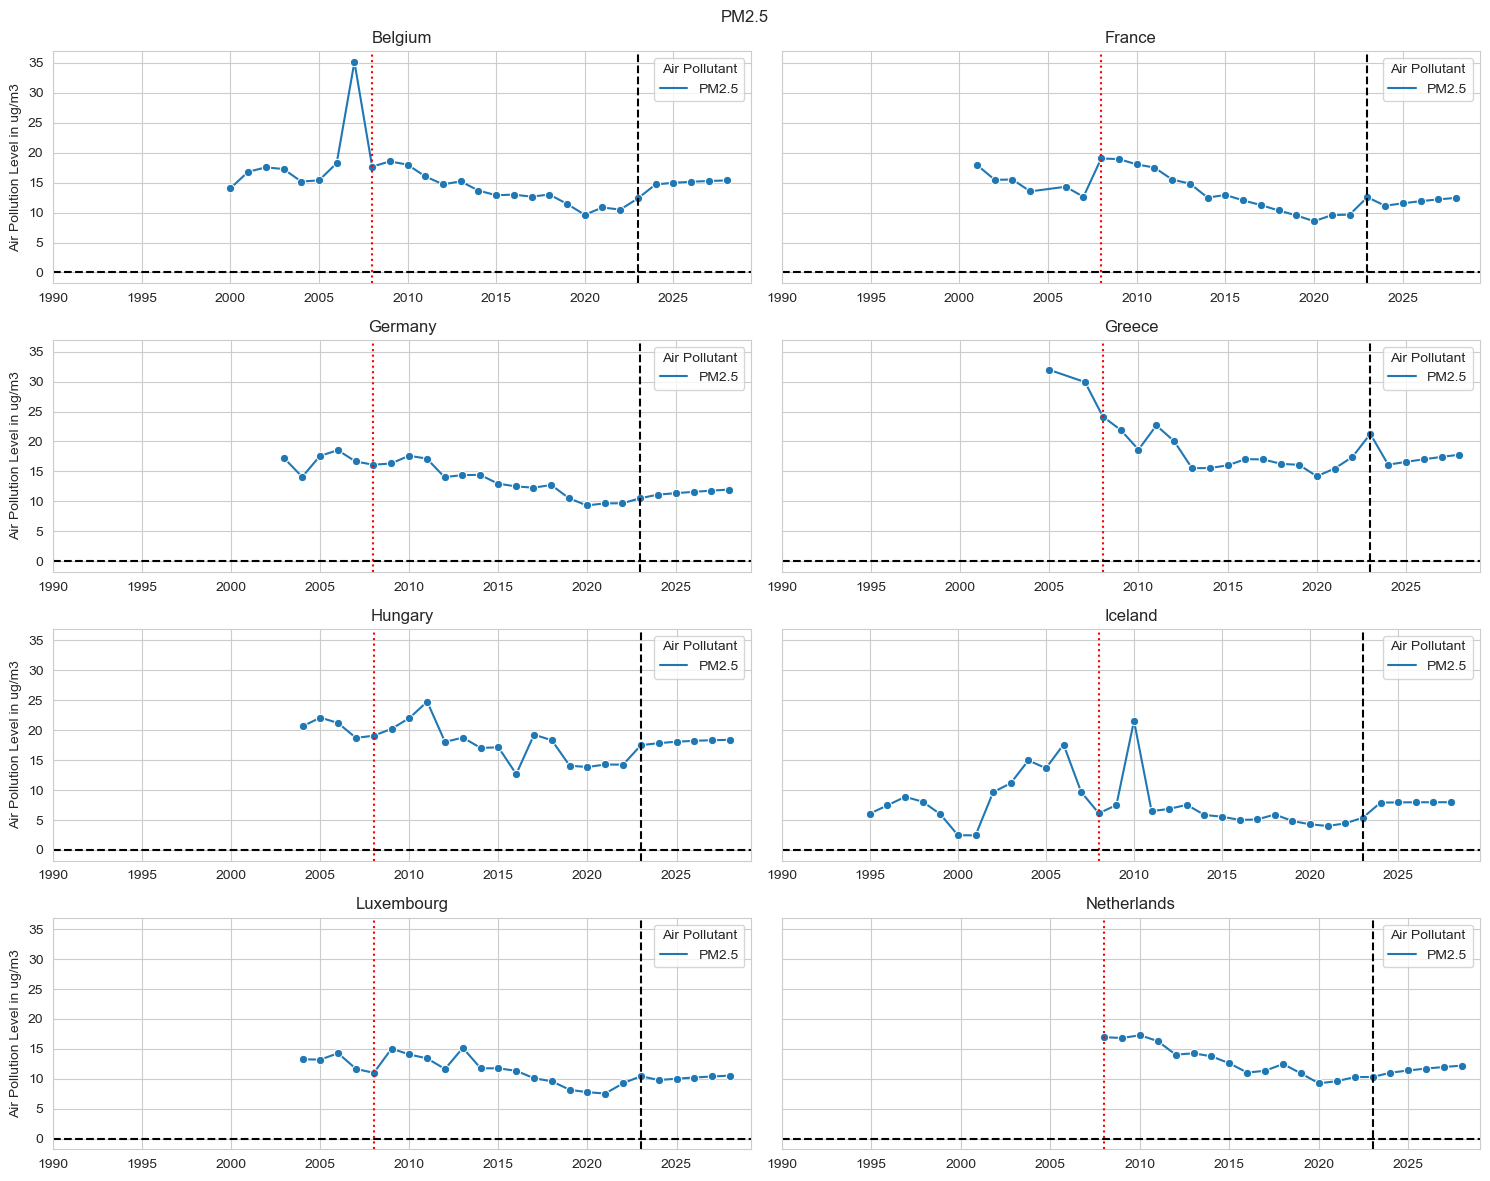

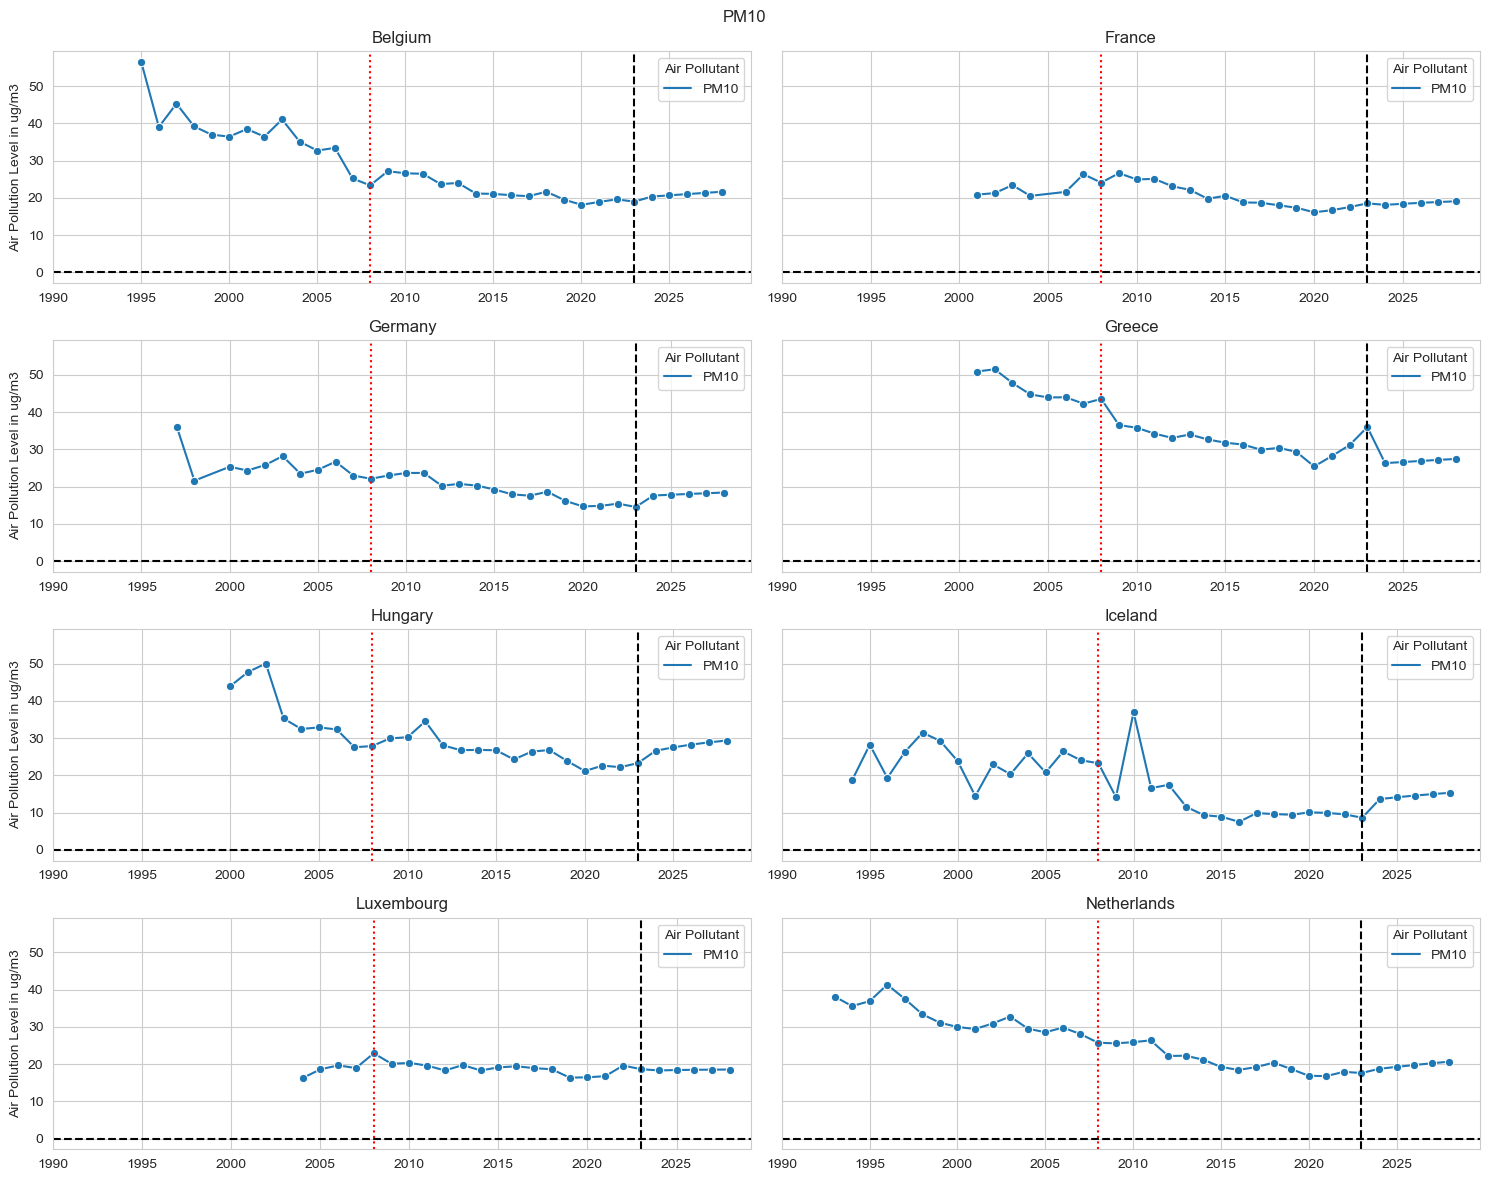

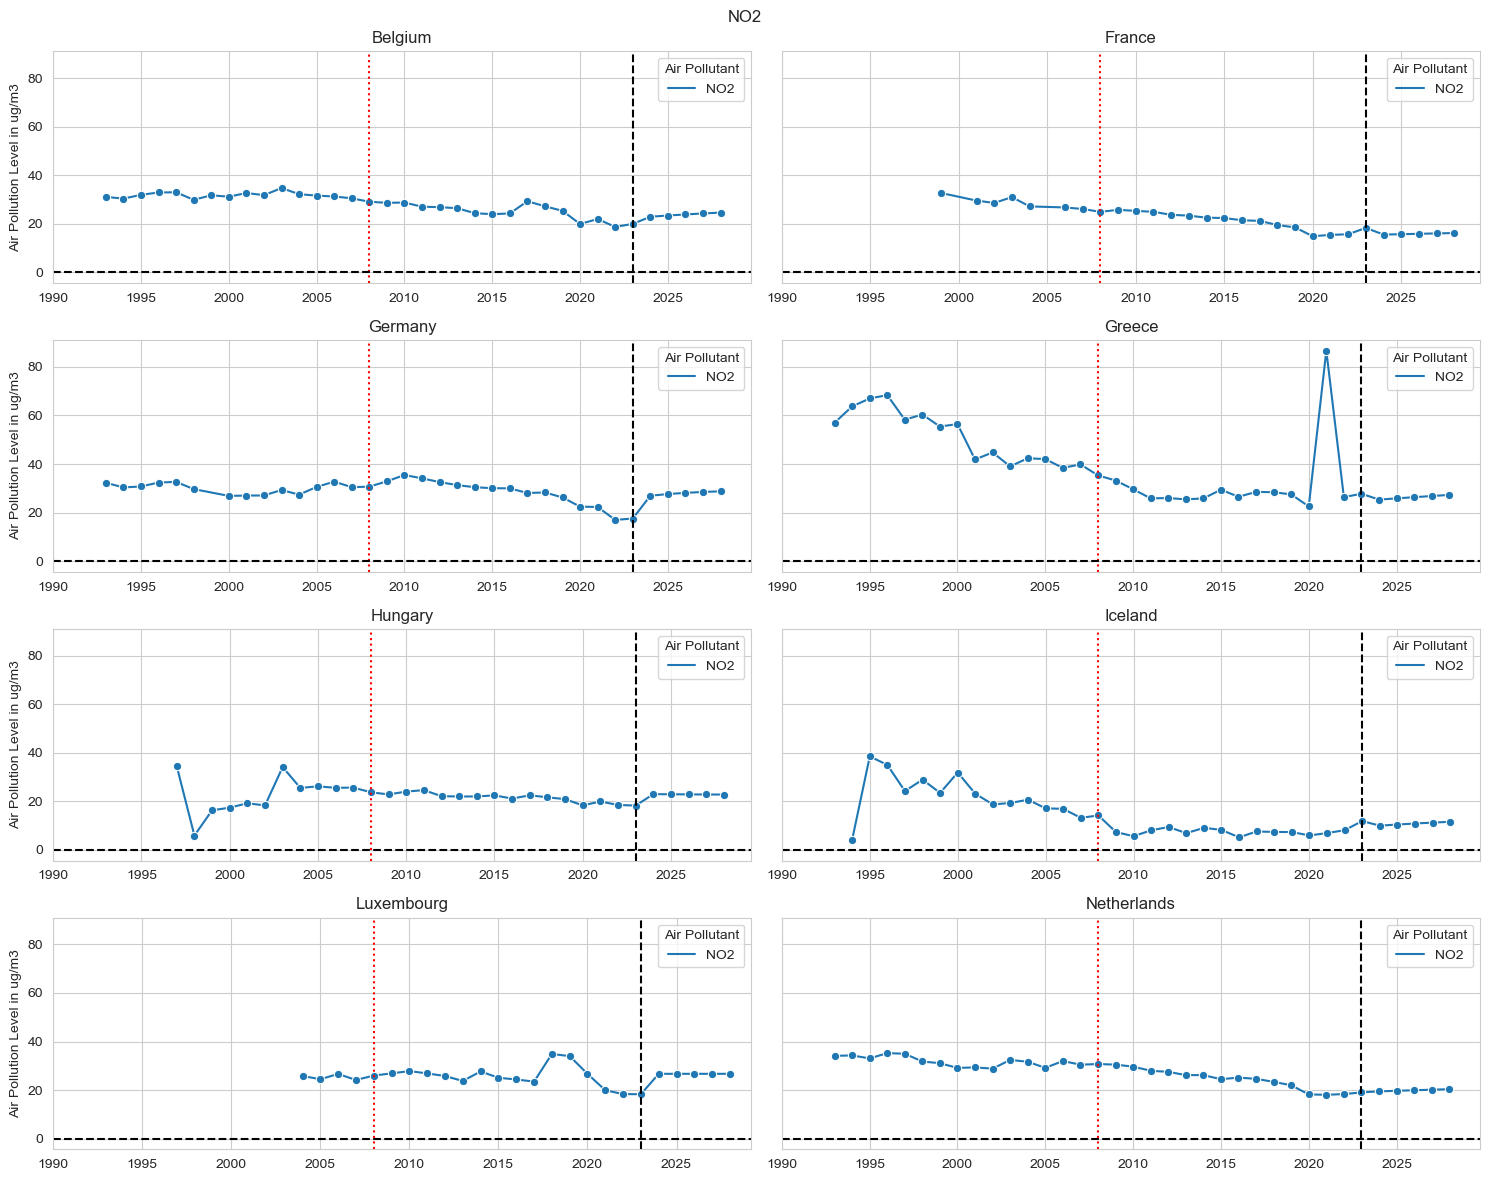

In [17]:
forecast = poll_df.copy().reset_index(drop=True)
arima_errors = pd.DataFrame(
    columns=['Country', 'Air Pollutant', 'Training MSE', 'Training R^2', 'Testing MSE', 'Testing R^2']
)

data = poll_df.set_index(['Country', 'Air Pollutant', 'Year'])
data.index = pd.MultiIndex.from_tuples(data.index, names=['Country', 'Air Pollutant', 'Year'])
data = data['Air Pollution Level']

# Convert data to time series object
data = data.unstack(['Country', 'Air Pollutant'])
data.index = pd.to_datetime(data.index.astype(str), format='%Y')

# Interpolate missing values
data = data.interpolate(method='from_derivatives')

# Define the training, testing and forecast ranges
train_end = pd.to_datetime('2020', format='%Y')
test_start = pd.to_datetime('2021', format='%Y')
test_end = pd.to_datetime('2023', format='%Y')
forecast_start = pd.to_datetime('2024', format='%Y')
forecast_end = pd.to_datetime('2028', format='%Y')

# Forecast for each country and air pollutant
for p in pollutants:
    fig, ax = plt.subplots(4, 2, tight_layout=True, figsize=(15, 12), sharey=True)
    pos_x, pos_y = 0, 0
    for x in data.columns.levels[0]:
        col = (x, p)
        X_train = data.loc[:train_end, col].dropna()
        X_test = data.loc[test_start:test_end, col].dropna()
        model = ARIMA(X_train, order=(1, 0, 1), freq='AS-JAN')

        # Compute training and testing error of the model
        model_fit = model.fit()
        y_train_hat = model_fit.predict(start=X_train.index.min(), end=X_train.index.max())
        y_test = model_fit.predict(start=X_test.index.min(), end=X_test.index.max())
        arima_errors.loc[len(arima_errors.index)] = [x, p] + compute_errors(
            X_train,
            y_train_hat.loc[X_train.index],
            X_test,
            y_test.loc[X_test.index],
        )

        # Forecast
        y_forecast = model_fit.predict(start=forecast_start, end=forecast_end)
        for i in y_forecast.index:
            if i.year > 2023:
                forecast.loc[len(forecast.index), :] = [col[0], col[1], i.year, y_forecast.loc[i]]

        # Plot the forecast
        temp = forecast.loc[(forecast['Country'] == x) & (forecast['Air Pollutant'] == p)]
        sns.lineplot(temp, x='Year', y='Air Pollution Level', hue='Air Pollutant', ax=ax[pos_x, pos_y], marker='o')
        ax[pos_x, pos_y].axvline(x=2008, color='r', linestyle=':')
        ax[pos_x, pos_y].axvline(x=2023, color='k', linestyle='--')
        ax[pos_x, pos_y].axhline(y=0, color='k', linestyle='--')
        ax[pos_x, pos_y].set_xticks(np.arange(1990, 2030, 5))
        ax[pos_x, pos_y].set_title(x)
        ax[pos_x, pos_y].set_xlabel("")
        ax[pos_x, pos_y].set_ylabel('Air Pollution Level in ug/m3')
        pos_y += 1
        if pos_y == 2:
            pos_x += 1
            pos_y = 0

    plt.suptitle(p)
    plt.show()

arima_errors = arima_errors.groupby(['Country', 'Air Pollutant']).mean()
arima_errors.columns = pd.MultiIndex.from_arrays([['Training', 'Training', 'Testing', 'Testing'],
                                               ['MSE', 'R^2', 'MSE', 'R^2']])

Let's compare the errors of both models.

In [18]:
print("Linear regression:")
print(lg_errors.to_string(float_format='%.2f'))

Linear regression:
                           Training         Testing         
                                MSE  R^2        MSE      R^2
Country     Air Pollutant                                   
Belgium     CO             25463.62 0.59   52237.09  -777.40
            NO2                4.08 0.64      15.86    -7.82
            PM10              12.58 0.86      32.68  -340.76
            PM2.5             19.33 0.19       1.37    -1.07
            SO2                3.83 0.88      18.33  -523.58
France      CO             13384.23 0.69   45510.04 -1362.19
            NO2                1.29 0.93       3.32    -0.97
            PM10               5.96 0.32       1.48    -1.62
            PM2.5              5.17 0.46       2.90    -0.50
            SO2                0.44 0.89       2.50  -204.51
Germany     CO             61335.11 0.01   85654.14     0.02
            NO2                7.03 0.06     101.69   -16.84
            PM10               6.09 0.69       0.43    -2.04
     

In [19]:
print("ARIMA:")
print(arima_errors.to_string(float_format='%.2f'))

ARIMA:
                           Training        Testing        
                                MSE   R^2      MSE     R^2
Country     Air Pollutant                                 
Belgium     CO             19732.38  0.68   393.86   -4.87
            NO2                4.16  0.64     5.26   -1.92
            PM10              38.85  0.56     0.39   -3.09
            PM2.5             20.57  0.14     6.76   -9.23
            SO2                5.65  0.83     0.33   -8.41
France      CO             10726.10  0.78    22.43    0.33
            NO2                5.65  0.69     2.97   -0.77
            PM10               3.09  0.63     0.21    0.63
            PM2.5              4.03  0.55     1.30    0.33
            SO2                0.86  0.81     0.02   -0.48
Germany     CO             51740.27  0.16 92961.59   -0.07
            NO2                3.13  0.57    44.16   -6.75
            PM10              16.74  0.11     5.17  -35.91
            PM2.5              2.99  0.54     0.4

Looking at the errors, we can see that both models achieve similar training errors. However, we can see that the `ARIMA` model is much more accurate on testing data than the `linear regression`. Moreover, looking at the plots, the `linear regression` model does not make sense as it outputs negative values, which can not be real.

Notice that the `R^2` metric for Hungary, CO is `NaN`. This is because we only have one data point available for the testing data.

Hence, we conclude that the `ARIMA` model is a model that can predict decently future pollution levels. Thanks to this, one would be able to estimate when new regulations should be added.

As an answer to the question **"Can we observe the impact of European Air Quality regulations?"**, we can see that in general the pollution level of all pollutants considered (as considered important in determining the safety of smog) is going done since 2008. 2008 is the year in which the `Ambient Air Quality Directive (2008/50/EC)`, one of the most significant pieces of legislation, was introduced.

Hence, we can conclude that these regulations had an impact in controlling the air quality in Europe. However, due to current trends in habits and pollution, we expect the air quality to become worse in the future, especially after 2025. This is as expected. Therefore, the European Commission should consider strengthening the current regulations in order to regulate air quality in Europe in the upcoming years.

### ETHICAL CONSIDERATIONS
The data itself was measured as most air quality is measured, with sensors on high up locations like traffic poles, and using satellite heat imagery. Given that this data is not personal to anyone, and the measurements are never precise enough to violate someone's privacy, there are essentially no ethical considerations for the data collection.

How we obtained this data however, could be the cause for ethical consideration. When trying to download the data, we encountered a setback where it turns out we can only download data in increments of 100,000 rows out of 1,500,000, this would've taken a lot of time to compile, so instead we automated the process using webscraping. Webscraping is usually not allowed for most websites due to the prevalence of bots, however, we did not see any website specific rulings on the dis-allowance of webscraping. Plus, the only reason we used webscraping is to shorten the length of menial labour, so we may spend more time on actual Data Analysis.

To Conclude we did use webscraping to collect data slightly faster than manually downloading the data in increments, but this has minor ramifications.